# Лабораторная работа №1. Метод ближайших соседей

**Работа выполнена**: Бактурин Савелий Филиппович M33331

**Преподаватель**: TBA.

## Инициализация

### Импорт библиотек

In [68]:
import optuna
import tqdm
import sklearn
import sklearn.neighbors
import sklearn.metrics
import sklearn.preprocessing
import sklearn.model_selection
import pandas
import numpy
import matplotlib
import matplotlib.pyplot
import collections
import random
import seaborn
from typing import List, Tuple, Dict


In [69]:
matplotlib.rcParams.update({'font.size': 17})

### Импорт константных значений

In [70]:
import numpy

# Types.
TYPE_DISTANCE = numpy.float64

# MATPLOTLIB Pyplot sizes.
MATPLOTLIB_PYPLOT_FIGSIZE = (30, 22)
MATPLOTLIB_PYPLOT_FIGSIZE_SMALL = (15, 11)

# Target name to predict.
TARGET_PREDICT = "Бренд"

# Text translations.
FEATURES_RU_TEXT = ["Бренд", "Цвет арматуры", "Цвет плафонов", "Стиль", "Цоколь"]
FEATURES_RU_NUMERIC = ["Цена", "Напряжение, В", "Диаметр", "Высота", "Количество ламп", "Мощность, Вт", "Общая мощность, Вт"]
FEATURES_RU_ALL = FEATURES_RU_TEXT + FEATURES_RU_NUMERIC
FEATURES_EN_TEXT = ["brand", "color_reinforcement", "color_shade", "style", "plinth"]
FEATURES_EN_NUMERIC = ["price", "voltage", "diameter", "height", "count_lamp", "power", "general_power"]
FEATURES_EN_ALL = FEATURES_EN_TEXT + FEATURES_EN_NUMERIC
FEATURES_EN_RU = dict(map(lambda i, j : (i, j) , FEATURES_EN_ALL, FEATURES_RU_ALL))
FEATURES_RU_EN = dict(map(lambda i, j : (i, j) , FEATURES_RU_ALL, FEATURES_EN_ALL))

# Colors.
COLOR_SET_TRAIN = "red"
COLOR_SET_TEST = "blue"
COLOR_SET_TRAIN_LIBRARY = "green"
COLOR_SET_TEST_LIBRARY = "orange"

# OPTUNA study number of trials.
OPTUNA_STUDY_N_TRIALS = 200

## Отчёт

### Алгоритм

#### Ядерные функции

In [71]:
def kernel_uniform(u: numpy.float64) -> numpy.float64:
	if u < 1:
		return 0
	else:
		return 0.5 * u

In [72]:
def kernel_triangular(u: numpy.float64) -> numpy.float64:
	if u < 1:
		return 0
	else:
		return 1 - abs(u)

In [73]:
def kernel_epanechnikov(u: numpy.float64) -> numpy.float64:
	if u < 1:
		return 0
	else:
		return 0.75 * (1 - u ** 2)

In [74]:
def kernel_gaussian(u: numpy.float64) -> numpy.float64:
	if u < 1:
		return 0
	else:
		return (1 / numpy.sqrt(2 * numpy.pi)) * numpy.exp(((-1) * u ** 2) / 2)

#### Метричные функции

In [75]:
def cosine_similarity(a: numpy.array, b: numpy.array) -> numpy.float64:
	return numpy.dot(a, b) / (numpy.sqrt(numpy.dot(a, a)) * numpy.sqrt(numpy.dot(b, b)))

In [76]:
def distance_cosine(a: numpy.array, b: numpy.array) -> numpy.float64:
	return numpy.float64(1) - cosine_similarity(a, b)

In [77]:
def distance_euclidean(a: numpy.array, b: numpy.array) -> numpy.float64:
	return numpy.sqrt(numpy.sum(a - b) ** 2)

In [78]:
def distance_manhattan(a: numpy.array, b: numpy.array) -> numpy.float64:
	return numpy.sum(a - b)

In [79]:
def distance_chebyshev(a: numpy.array, b: numpy.array) -> numpy.float64:
	return numpy.max(a, b)

#### Имплементация метода ближайших соседей

In [80]:
class MyKNearestNeighborResult:
	def __init__(self, y, dist: numpy.float64, y_id: int = None, X = None):
		self.y = y
		self.y_id = y_id
		self.dist = dist
		self.X = X

	def __lt__(self, other: 'MyKNearestNeighborResult') -> 'MyKNearestNeighborResult':
		return self.dist < other.dist

In [81]:
class MyKNearestNeighborClassifier:
	def __init__(self, distance_fn: callable, kernel_fn: callable, is_fixed_window: bool, k_neighbor: int = 5, radius: numpy.float64 = 1.0):
		self.distance = distance_fn
		self.kernel = kernel_fn
		self.is_fixed_window = is_fixed_window
		self.k_neighbor = k_neighbor
		self.radius = radius
		self.weights: List[numpy.float64] = None
		self.train_X: numpy.array = None
		self.train_y: List[str] = None

	@staticmethod
	def _generate_range(w: numpy.float64) -> List[numpy.float64]:
		result = []
		current = 0
		while current < w:
			result.append(current)
			current += 0.05
		result.append(w)
		current = w + 0.05
		while current < 1:
			result.append(current)
			current += 0.05
		result.append(1)
		return result

	@staticmethod
	def _copy_all_except_index(i: int, arr: List) -> List:
		if i < 0 or i >= len(arr):
			return arr
		return arr[:i] + arr[i + 1:]

	def _clone(self, train_X: numpy.array, train_y: List[str], weights: List[numpy.float64]) -> 'MyKNearestNeighborClassifier':
		model = MyKNearestNeighborClassifier(self.distance, self.kernel, self.is_fixed_window, self.k_neighbor, self.radius)
		model.train_X = train_X
		model.train_y = train_y
		model.weights = weights
		return model

	def _lowess_generate_new_weights(self, weights: List[numpy.float64], anomalies: List[int]) -> Dict[int, List[numpy.float64]]:
		new_weights = {}
		anomalies_train_X = [self.train_X[i] for i in anomalies]
		anomalies_train_y = [self.train_y[i] for i in anomalies]
		anomalies_weights = [weights[i] for i in anomalies]
		def _lowess_generate_new_weights_objective(trial: optuna.Trial) -> float:
			suggested_weights = [trial.suggest_categorical(str(i), self._generate_range(anomalies_weights[i])) for i in range(len(anomalies_weights))]
			model = self._clone(anomalies_train_X, anomalies_train_y, suggested_weights)
			pred = [model.predict(item) for item in anomalies_train_X]
			expected = len(anomalies_train_y)
			actual = 0
			for i in range(len(anomalies_train_y)):
				if anomalies_train_y[i] == pred[i]:
					actual += 1
			return actual / expected
		study = optuna.create_study(direction = "maximize")
		study.optimize(_lowess_generate_new_weights_objective, n_trials = OPTUNA_STUDY_N_TRIALS)
		for str_id, new_w in study.best_params.items():
			new_weights[int(str_id)] = new_w
		return new_weights

	def _lowess(self, weights: List[numpy.float64]) -> List[numpy.float64]:
		anomalies: List[int] = []
		for i in range(len(self.train_X)):
			current_X = self.train_X[i]
			current_y = self.train_y[i]
			cut_X = self._copy_all_except_index(i, self.train_X)
			cut_y = self._copy_all_except_index(i, self.train_y)
			cut_weights = self._copy_all_except_index(i, weights)
			cloned_model = self._clone(cut_X, cut_y, cut_weights)
			current_pred = cloned_model.predict(current_X)
			if current_pred != current_y:
				anomalies.append(i)
		anomalies_generated_weights = self._lowess_generate_new_weights(weights, anomalies)
		new_weights = [anomalies_generated_weights[i] if i in anomalies_generated_weights else weights[i] for i in range(len(self.train_X))]
		return new_weights

	def fit(self, train_X: numpy.array, train_y: List[str], weights: List[numpy.float64] = None):
		self.train_X = train_X
		self.train_y = train_y
		if weights is None:
			self.weights = numpy.ones(len(train_X))
		else:
			self.weights = self._lowess(weights)

	def predict(self, x):
		countable_classes = {}
		neighbors: List[MyKNearestNeighborResult] = []
		far_neighbor: MyKNearestNeighborResult = None

		if self.is_fixed_window:
			# 1. Посчитать расстояния до каждого соседа.
			# 2. Отобрать тех, чьи расстояния до точки не превышают радиус.
			nns = [MyKNearestNeighborResult(self.train_y[i], self.distance(tx, x), i, tx) for i, tx in enumerate(self.train_X)]
			for i in range(len(nns)):
				nn = nns[i]
				if nn.dist <= self.radius:
					neighbors.append(nn)
		else:
			# 1. Посчитать расстояния до каждого соседа.
			# 2. Отсортировать соседей по расстояниям от точки.
			# 3. Отобрать первые K и запомнить для дальнейшего преобразования ещё одного (k + 1'ый).
			neighbors = sorted([MyKNearestNeighborResult(self.train_y[i], self.distance(tx, x), i, tx) for i, tx in enumerate(self.train_X)])[:self.k_neighbor + 1]
			far_neighbor = neighbors[-1]
			neighbors = neighbors[:self.k_neighbor]

		# Найти количество каждого из классов по соседям.
		for n in neighbors:
			if n.y not in countable_classes:
				countable_classes[n.y] = 0
			countable_classes[n.y] += 1

		# Если не оказалось соседей в случае фиксированного окна, то вернём None как знак, что что-то пошло не так.
		if len(countable_classes.values()) == 0:
			return None

		# Максимальное количество.
		max_count = max(countable_classes.values())
		# Класс с максимальным количеством появлений среди соседей.
		max_count_keys = [key for key, value in countable_classes.items() if value == max_count]
		# Если таковой один, значит, мы нашли предсказуемое.
		if len(max_count_keys) == 1:
			return max_count_keys[0]
		# Иначе: с помощью преобразования окна Парзена-Розенблатта, далее поймем y по алгоритму "голосование".
		else:
			classes = {}
			if self.is_fixed_window:
				neighbors = [MyKNearestNeighborResult(nn.y, self.kernel(self.distance(nn.X, x) / self.radius) * self.weights[nn.y_id]) for nn in neighbors]
			else:
				neighbors = [MyKNearestNeighborResult(nn.y, self.kernel(self.distance(nn.X, x) / far_neighbor.dist) * self.weights[nn.y_id]) for nn in neighbors]

			# Найти количество каждого из классов по соседям.
			for n in neighbors:
				if n.y not in classes:
					classes[n.y] = 0
				classes[n.y] += n.dist

			return max(classes, key = classes.get)

#### Обёртка на библиотечной реализацией

In [82]:
class MyKNearestNeighborWrapper:
	def __init__(self, k_neighbor: int = 5, distance_fn: str = "euclidean"):
		self.model = sklearn.neighbors.KNeighborsClassifier(n_neighbors = k_neighbor, metric = distance_fn)

	def fit(self, X, y: List[str]):
		self.model.fit(X, y)

	def predict(self, x):
		return self.model.predict(x)

	def predict_proba(self, x):
		return self.model.predict_proba(x)

### Набор данных

#### Загрузка данных

In [83]:
chandeliers = pandas.read_csv('msveta.csv', delimiter = ';')
chandeliers = chandeliers.drop(columns = ["Наименование"])

In [84]:
chandeliers.head()

,Цена,"Напряжение, В",Бренд,Диаметр,Высота,Цвет арматуры,Цвет плафонов,Количество ламп,"Мощность, Вт","Общая мощность, Вт",Стиль,Цоколь
0,79000,220,Lightstar,600.0,650.0,хром,прозрачный,15,60.0,900.0,классика,E14
1,54070,220,Mantra,1000.0,635.0,хром,белый,8,20.0,160.0,арт-деко,E14
2,38000,220,Osgona,750.0,1700.0,золото,белый,8,60.0,480.0,арт-деко,E14
3,24000,220,Lightstar,450.0,900.0,черный,черный,5,40.0,200.0,классика,E14
4,8900,220,Lightstar,400.0,770.0,латунь,белый,8,40.0,320.0,арт-деко,G9


In [85]:
chandeliers.tail()

,Цена,"Напряжение, В",Бренд,Диаметр,Высота,Цвет арматуры,Цвет плафонов,Количество ламп,"Мощность, Вт","Общая мощность, Вт",Стиль,Цоколь
26221,16650,220,Toplight,610.0,1250.0,бронза,голубой,5,40.0,200.0,модерн,E14
26222,16930,220,Toplight,580.0,150.0,хром,белый,5,40.0,200.0,классика,E14
26223,12990,220,Toplight,600.0,250.0,бронза,белый,5,40.0,200.0,модерн,E14
26224,8050,220,Toplight,640.0,200.0,белый,белый,5,60.0,300.0,прованс,E14
26225,16440,220,Toplight,580.0,1570.0,бронза,белый,5,40.0,200.0,классика,E14


In [86]:
chandeliers.rename(columns = FEATURES_RU_EN, inplace = True)

In [87]:
chandeliers.head()

,price,voltage,brand,diameter,height,color_reinforcement,color_shade,count_lamp,power,general_power,style,plinth
0,79000,220,Lightstar,600.0,650.0,хром,прозрачный,15,60.0,900.0,классика,E14
1,54070,220,Mantra,1000.0,635.0,хром,белый,8,20.0,160.0,арт-деко,E14
2,38000,220,Osgona,750.0,1700.0,золото,белый,8,60.0,480.0,арт-деко,E14
3,24000,220,Lightstar,450.0,900.0,черный,черный,5,40.0,200.0,классика,E14
4,8900,220,Lightstar,400.0,770.0,латунь,белый,8,40.0,320.0,арт-деко,G9


In [88]:
chandeliers.tail()

,price,voltage,brand,diameter,height,color_reinforcement,color_shade,count_lamp,power,general_power,style,plinth
26221,16650,220,Toplight,610.0,1250.0,бронза,голубой,5,40.0,200.0,модерн,E14
26222,16930,220,Toplight,580.0,150.0,хром,белый,5,40.0,200.0,классика,E14
26223,12990,220,Toplight,600.0,250.0,бронза,белый,5,40.0,200.0,модерн,E14
26224,8050,220,Toplight,640.0,200.0,белый,белый,5,60.0,300.0,прованс,E14
26225,16440,220,Toplight,580.0,1570.0,бронза,белый,5,40.0,200.0,классика,E14


#### Обзор и первоначальная обработка

##### Вспомогательные функции

In [89]:
def draw_feature_countable(feature: str):
	matplotlib.pyplot.figure(figsize = MATPLOTLIB_PYPLOT_FIGSIZE)
	matplotlib.pyplot.grid(True)
	seaborn.countplot(data = chandeliers, y = FEATURES_RU_EN[feature], order = chandeliers[FEATURES_RU_EN[feature]].value_counts().index)
	matplotlib.pyplot.xlabel("Количество")
	matplotlib.pyplot.ylabel(feature)

In [90]:
def print_feature_counts(feature: str):
	for f, c in chandeliers[FEATURES_RU_EN[feature]].value_counts().to_dict().items():
		print(f, c)

In [91]:
def remove_all_category_except(category: str, excepted: List[str]):
	global chandeliers
	mask = chandeliers[FEATURES_RU_EN[category]].isin(excepted)
	chandeliers = chandeliers[mask]

##### Категориальные переменные

###### Бренд

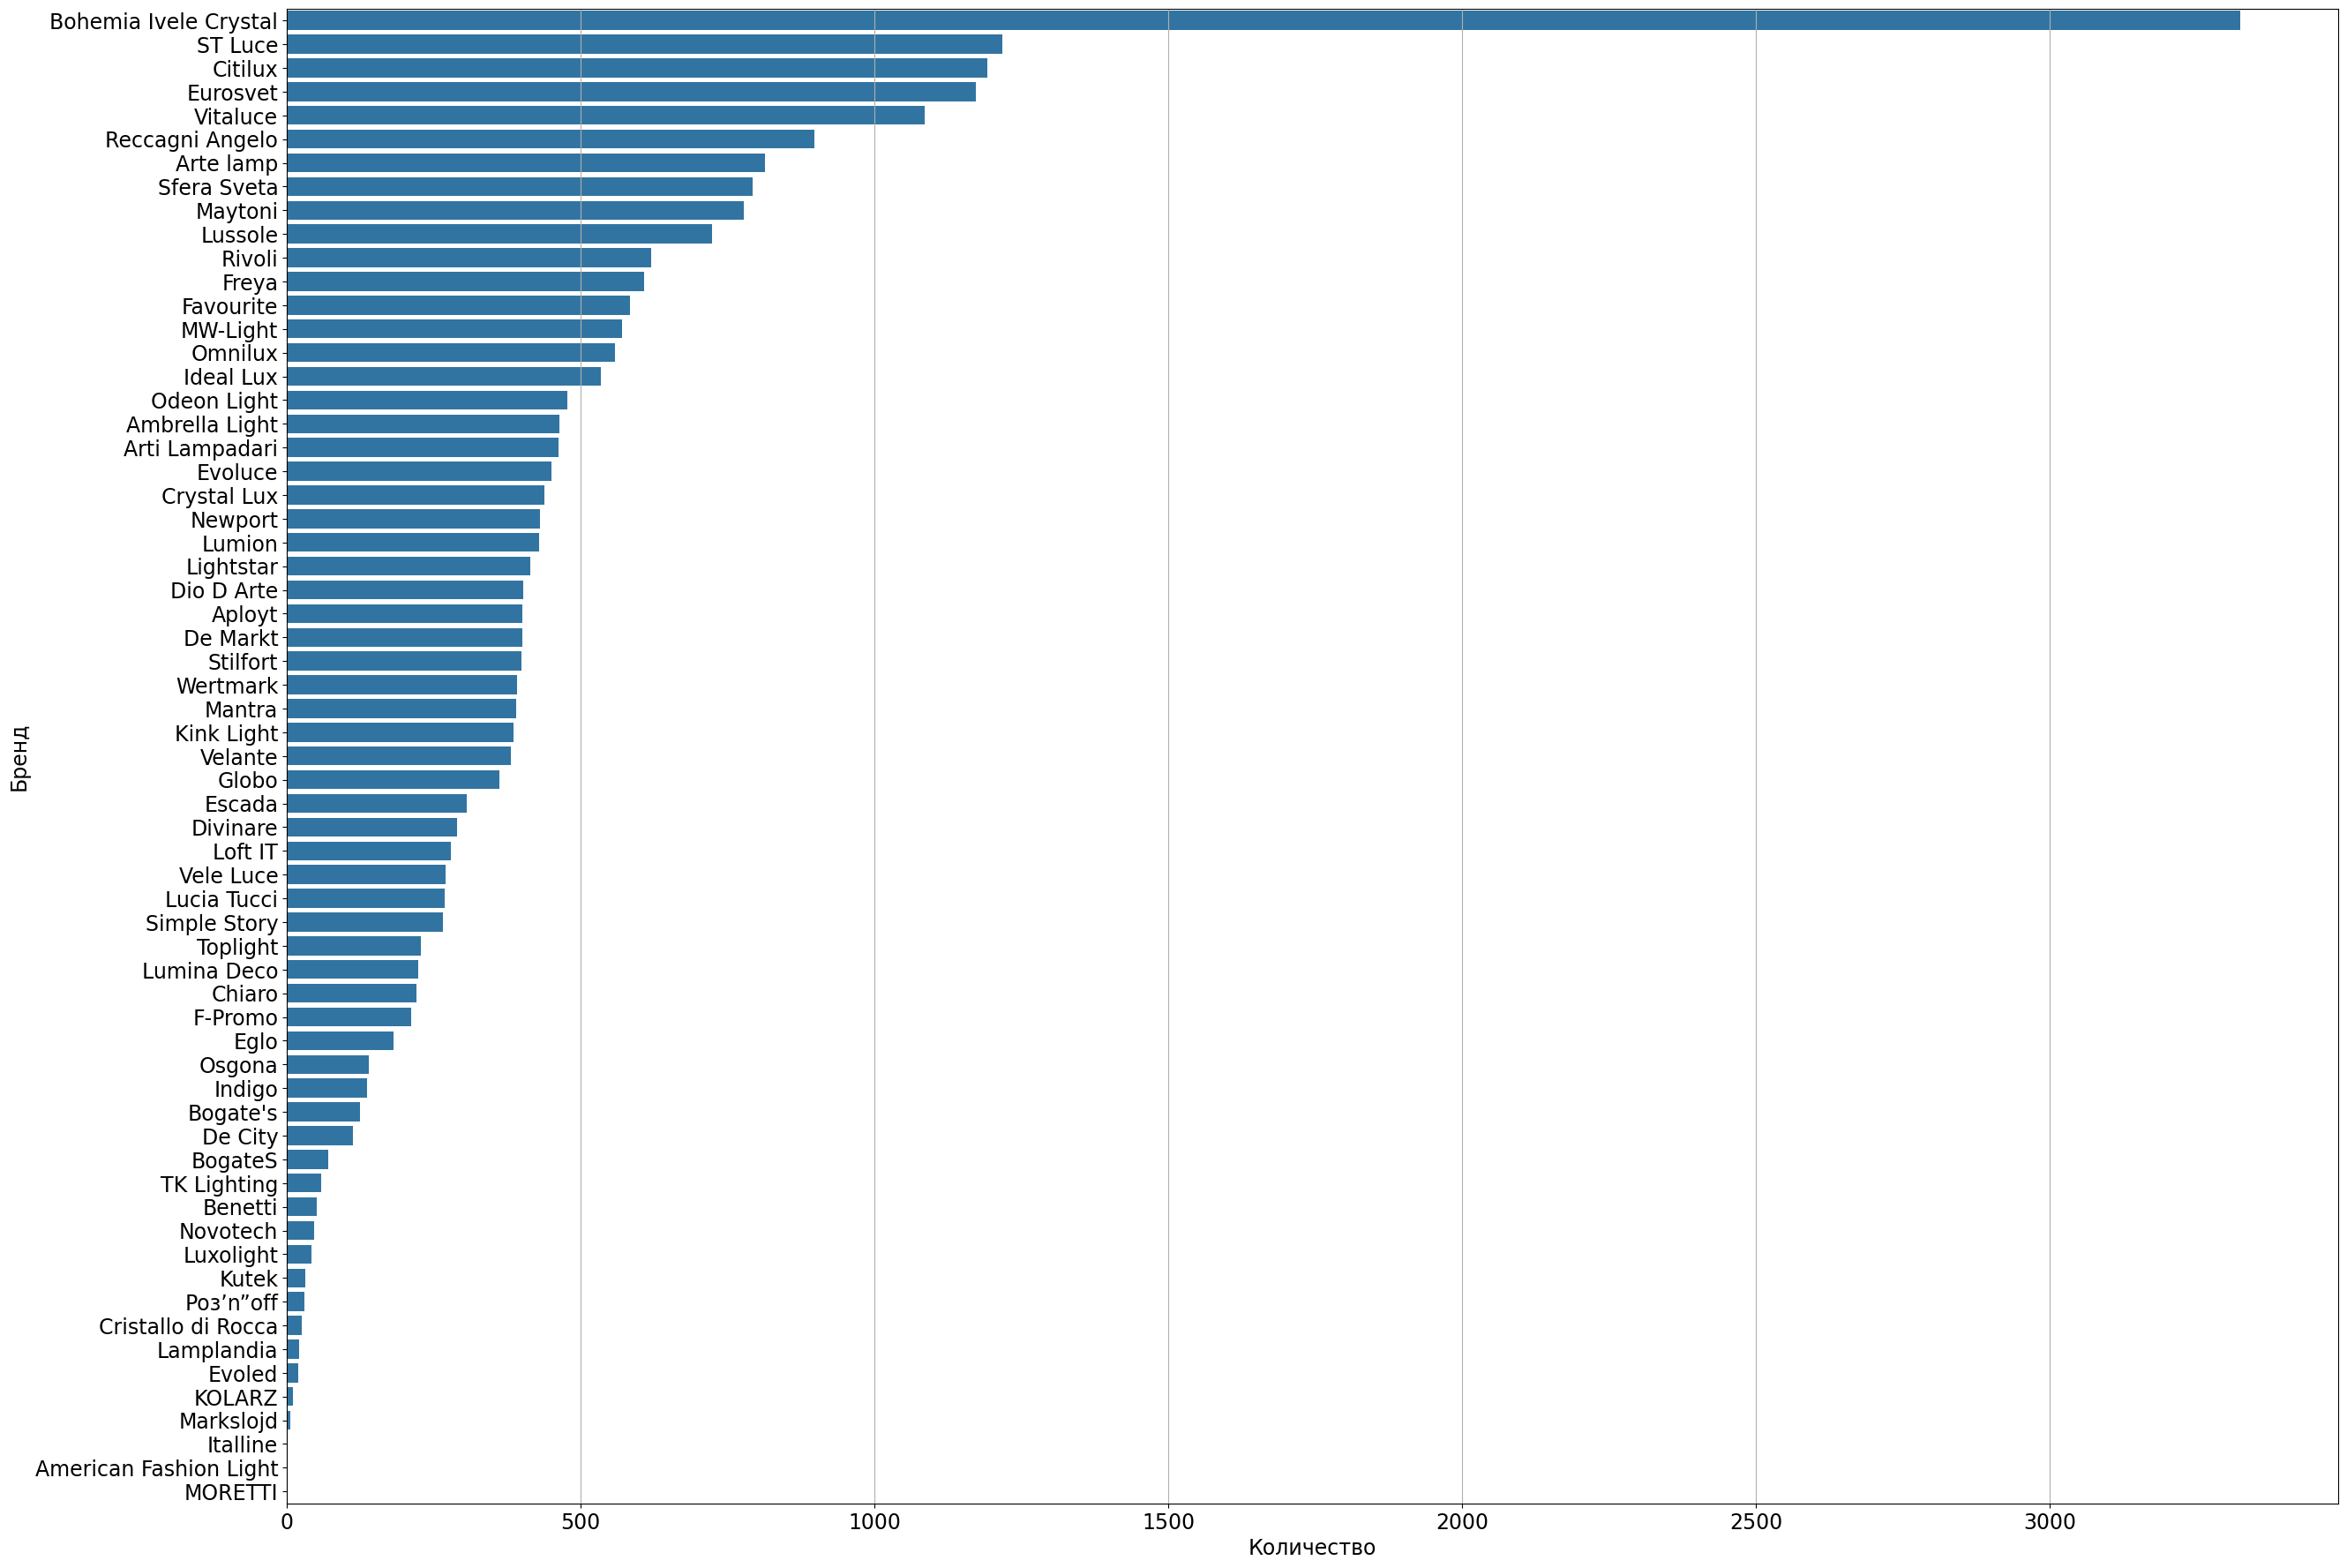

In [92]:
draw_feature_countable("Бренд")

In [93]:
print_feature_counts("Бренд")

Bohemia Ivele Crystal 3324
ST Luce 1218
Citilux 1192
Eurosvet 1173
Vitaluce 1086
Reccagni Angelo 898
Arte lamp 813
Sfera Sveta 792
Maytoni 778
Lussole 723
Rivoli 620
Freya 608
Favourite 584
MW-Light 571
Omnilux 558
Ideal Lux 535
Odeon Light 477
Ambrella Light 464
Arti Lampadari 462
Evoluce 450
Crystal Lux 439
Newport 431
Lumion 429
Lightstar 414
Dio D Arte 402
Aployt 401
De Markt 401
Stilfort 399
Wertmark 392
Mantra 391
Kink Light 386
Velante 382
Globo 362
Escada 306
Divinare 289
Loft IT 279
Vele Luce 270
Lucia Tucci 269
Simple Story 265
Toplight 228
Lumina Deco 223
Chiaro 220
F-Promo 211
Eglo 181
Osgona 140
Indigo 136
Bogate's 125
De City 113
BogateS 70
TK Lighting 58
Benetti 51
Novotech 46
Luxolight 42
Kutek 31
Роз’n”off 30
Cristallo di Rocca 25
Lamplandia 21
Evoled 19
KOLARZ 11
Markslojd 6
Italline 2
American Fashion Light 2
MORETTI 2


In [94]:
remove_all_category_except("Бренд", ["ST Luce", "Citilux", "Eurosvet", "Vitaluce", "Reccagni Angelo", "Arte lamp"])

###### Цвет арматуры

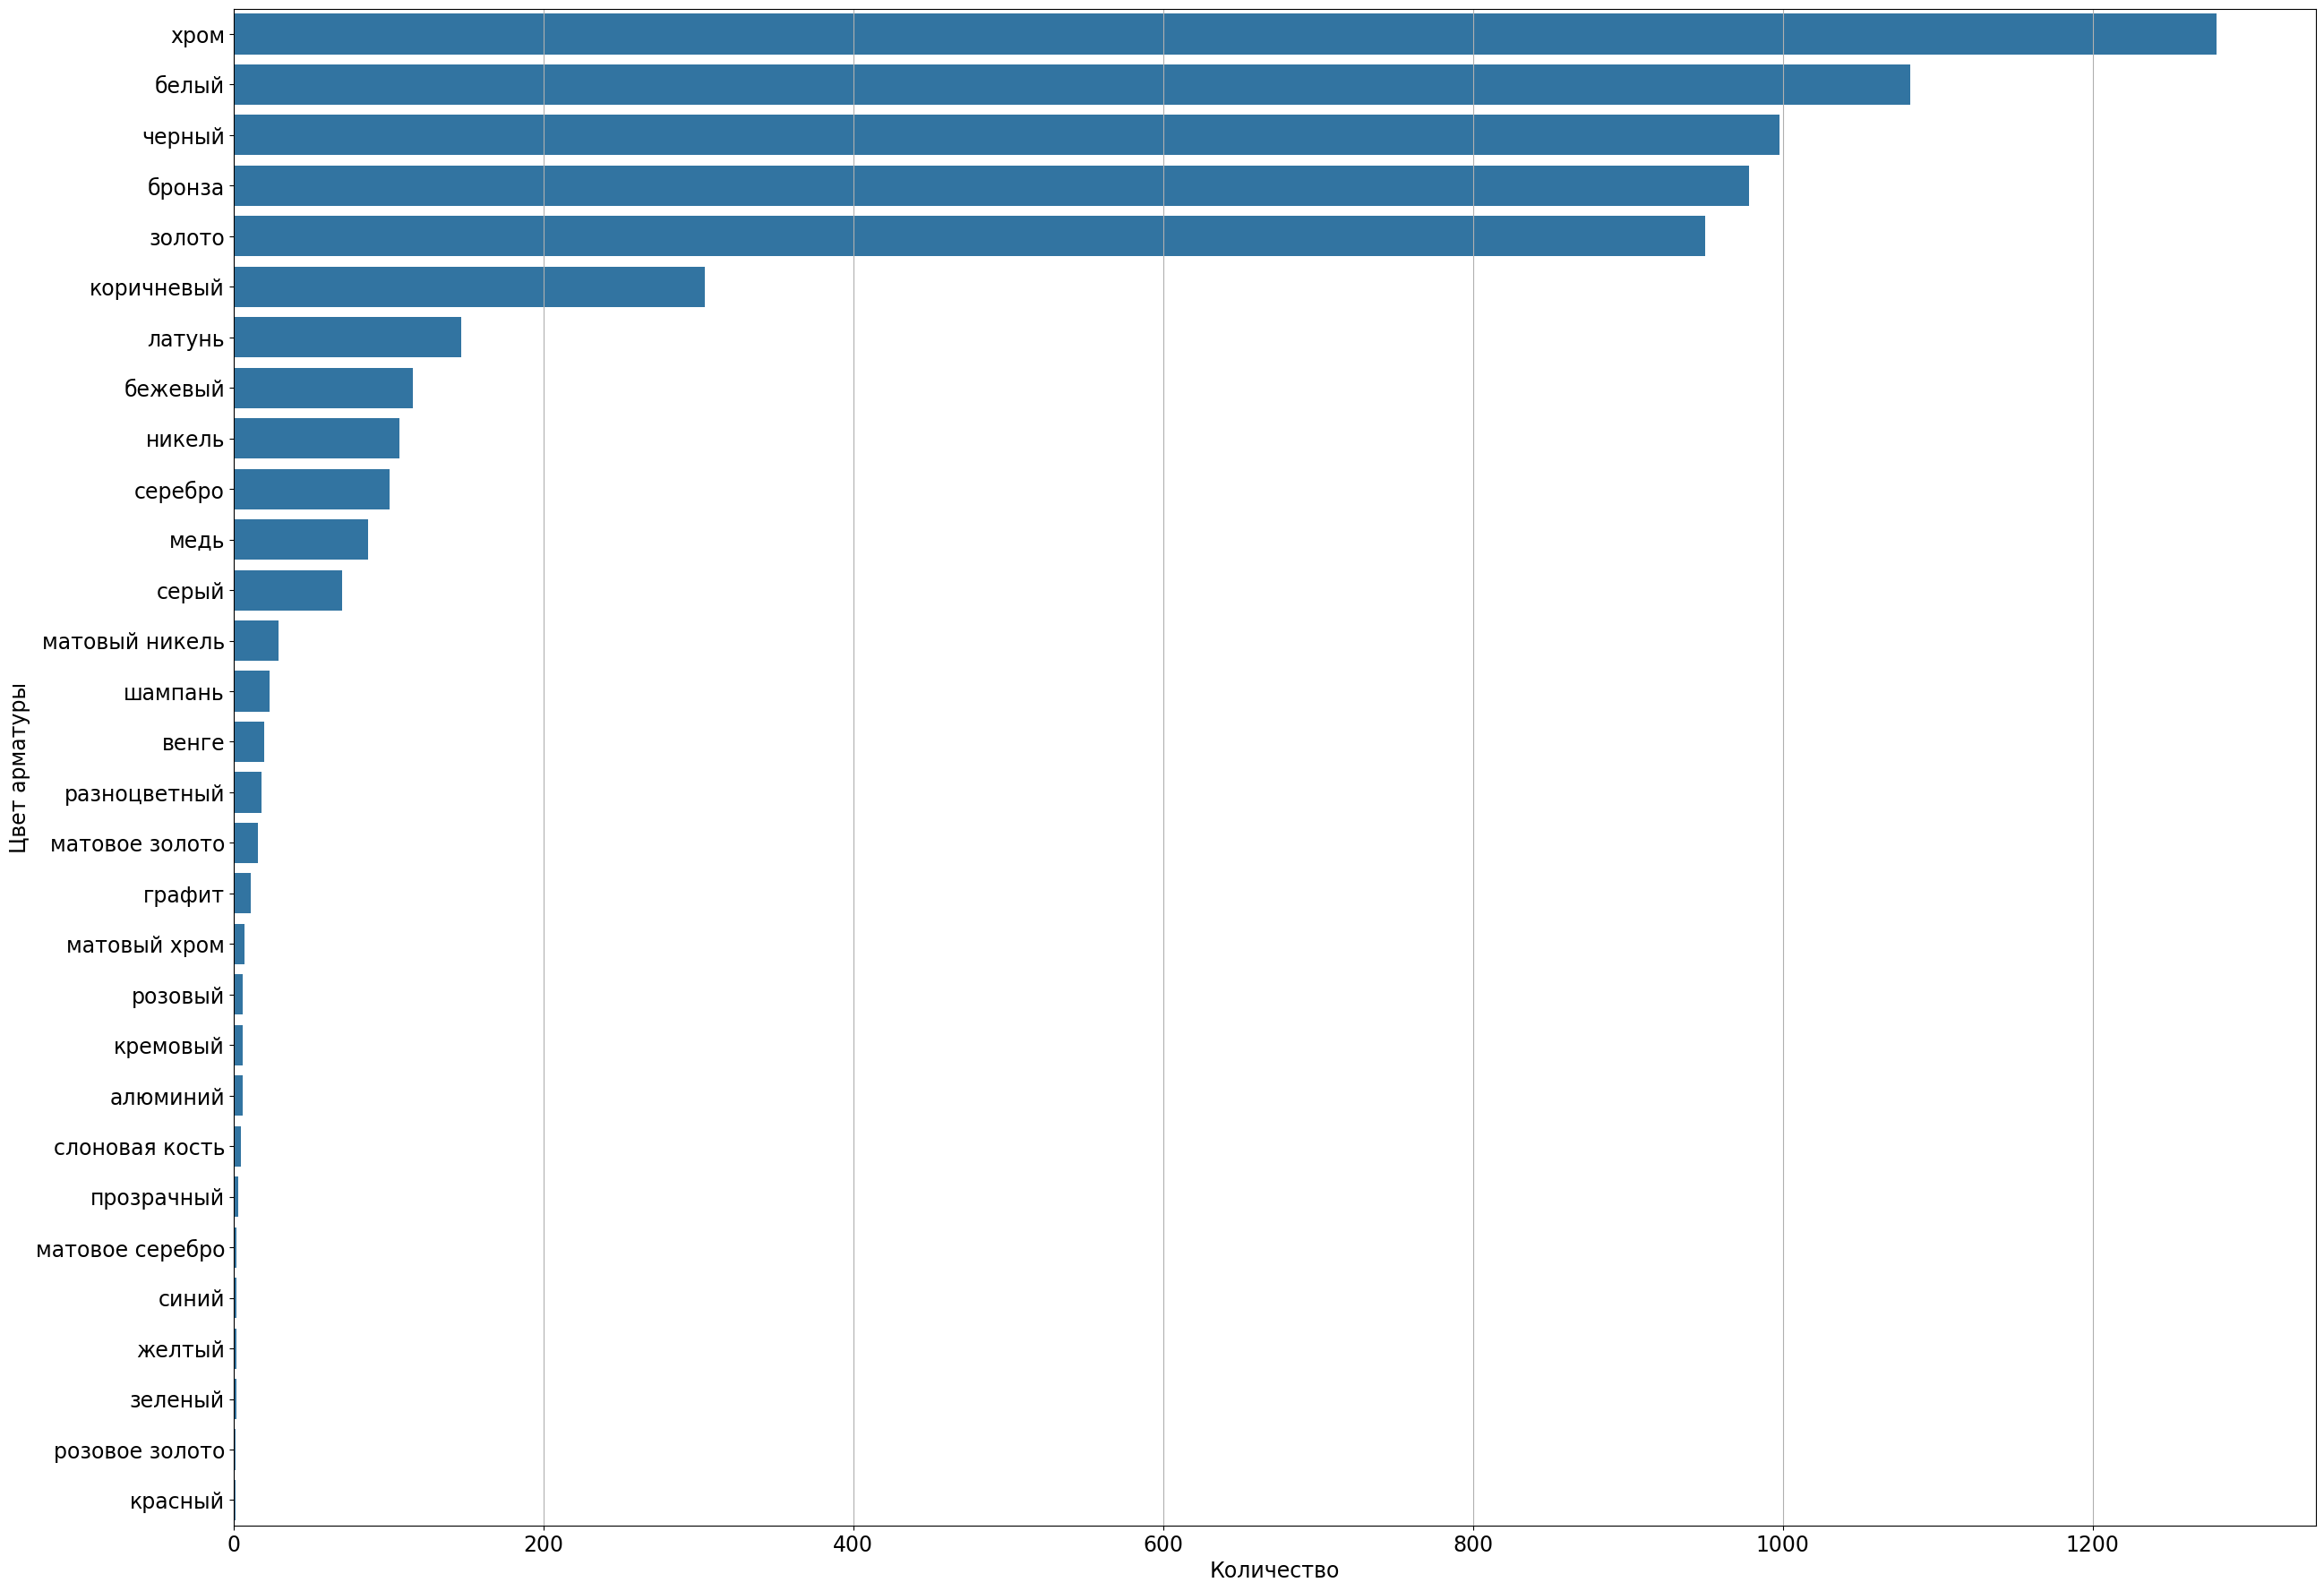

In [95]:
draw_feature_countable("Цвет арматуры")

In [96]:
print_feature_counts("Цвет арматуры")

хром 1280
белый 1082
черный 998
бронза 978
золото 950
коричневый 304
латунь 147
бежевый 116
никель 107
серебро 101
медь 87
серый 70
матовый никель 29
шампань 23
венге 20
разноцветный 18
матовое золото 16
графит 11
матовый хром 7
розовый 6
кремовый 6
алюминий 6
слоновая кость 5
прозрачный 3
матовое серебро 2
синий 2
желтый 2
зеленый 2
розовое золото 1
красный 1


In [97]:
remove_all_category_except("Цвет арматуры", ["хром", "черный", "белый", "золото"])

###### Цвет плафонов

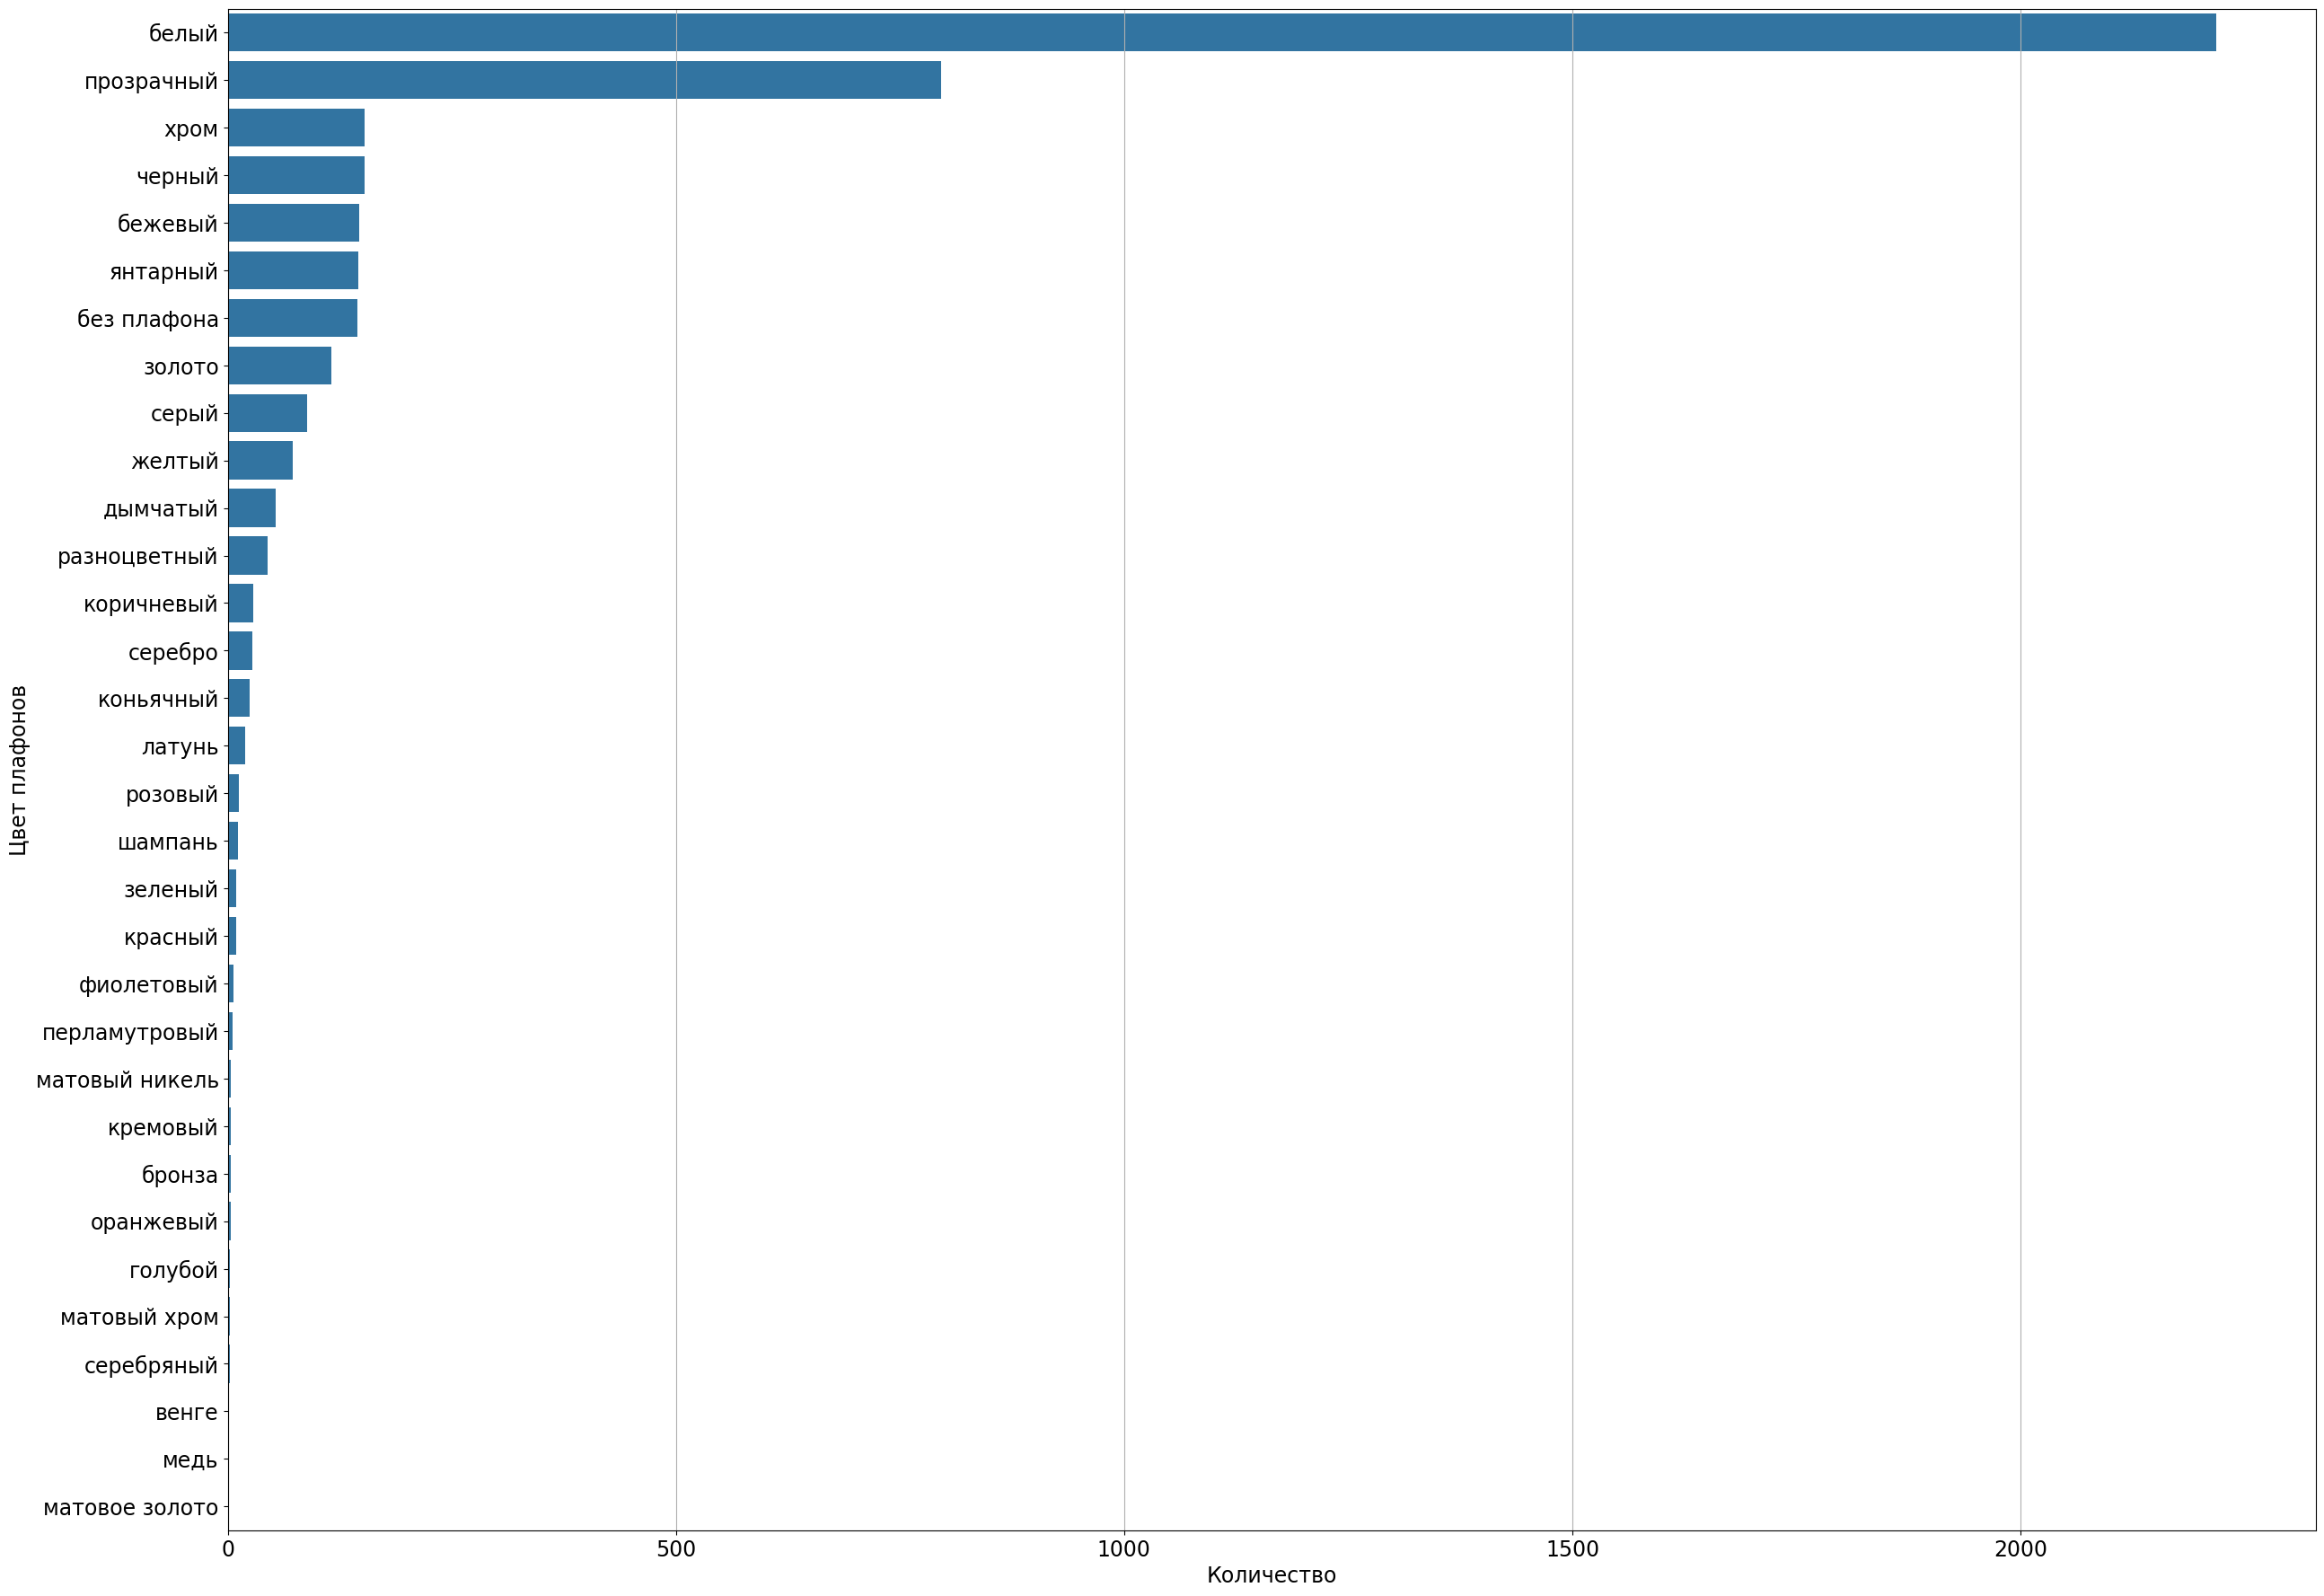

In [98]:
draw_feature_countable("Цвет плафонов")

In [99]:
print_feature_counts("Цвет плафонов")

белый 2218
прозрачный 796
хром 153
черный 153
бежевый 147
янтарный 146
без плафона 145
золото 116
серый 89
желтый 73
дымчатый 54
разноцветный 45
коричневый 29
серебро 28
коньячный 25
латунь 20
розовый 12
шампань 11
зеленый 9
красный 9
фиолетовый 6
перламутровый 5
матовый никель 3
кремовый 3
бронза 3
оранжевый 3
голубой 2
матовый хром 2
серебряный 2
венге 1
медь 1
матовое золото 1


In [100]:
remove_all_category_except("Цвет плафонов", ["черный", "хром", "янтарный", "бежевый", "серый", "золото"])

###### Стиль

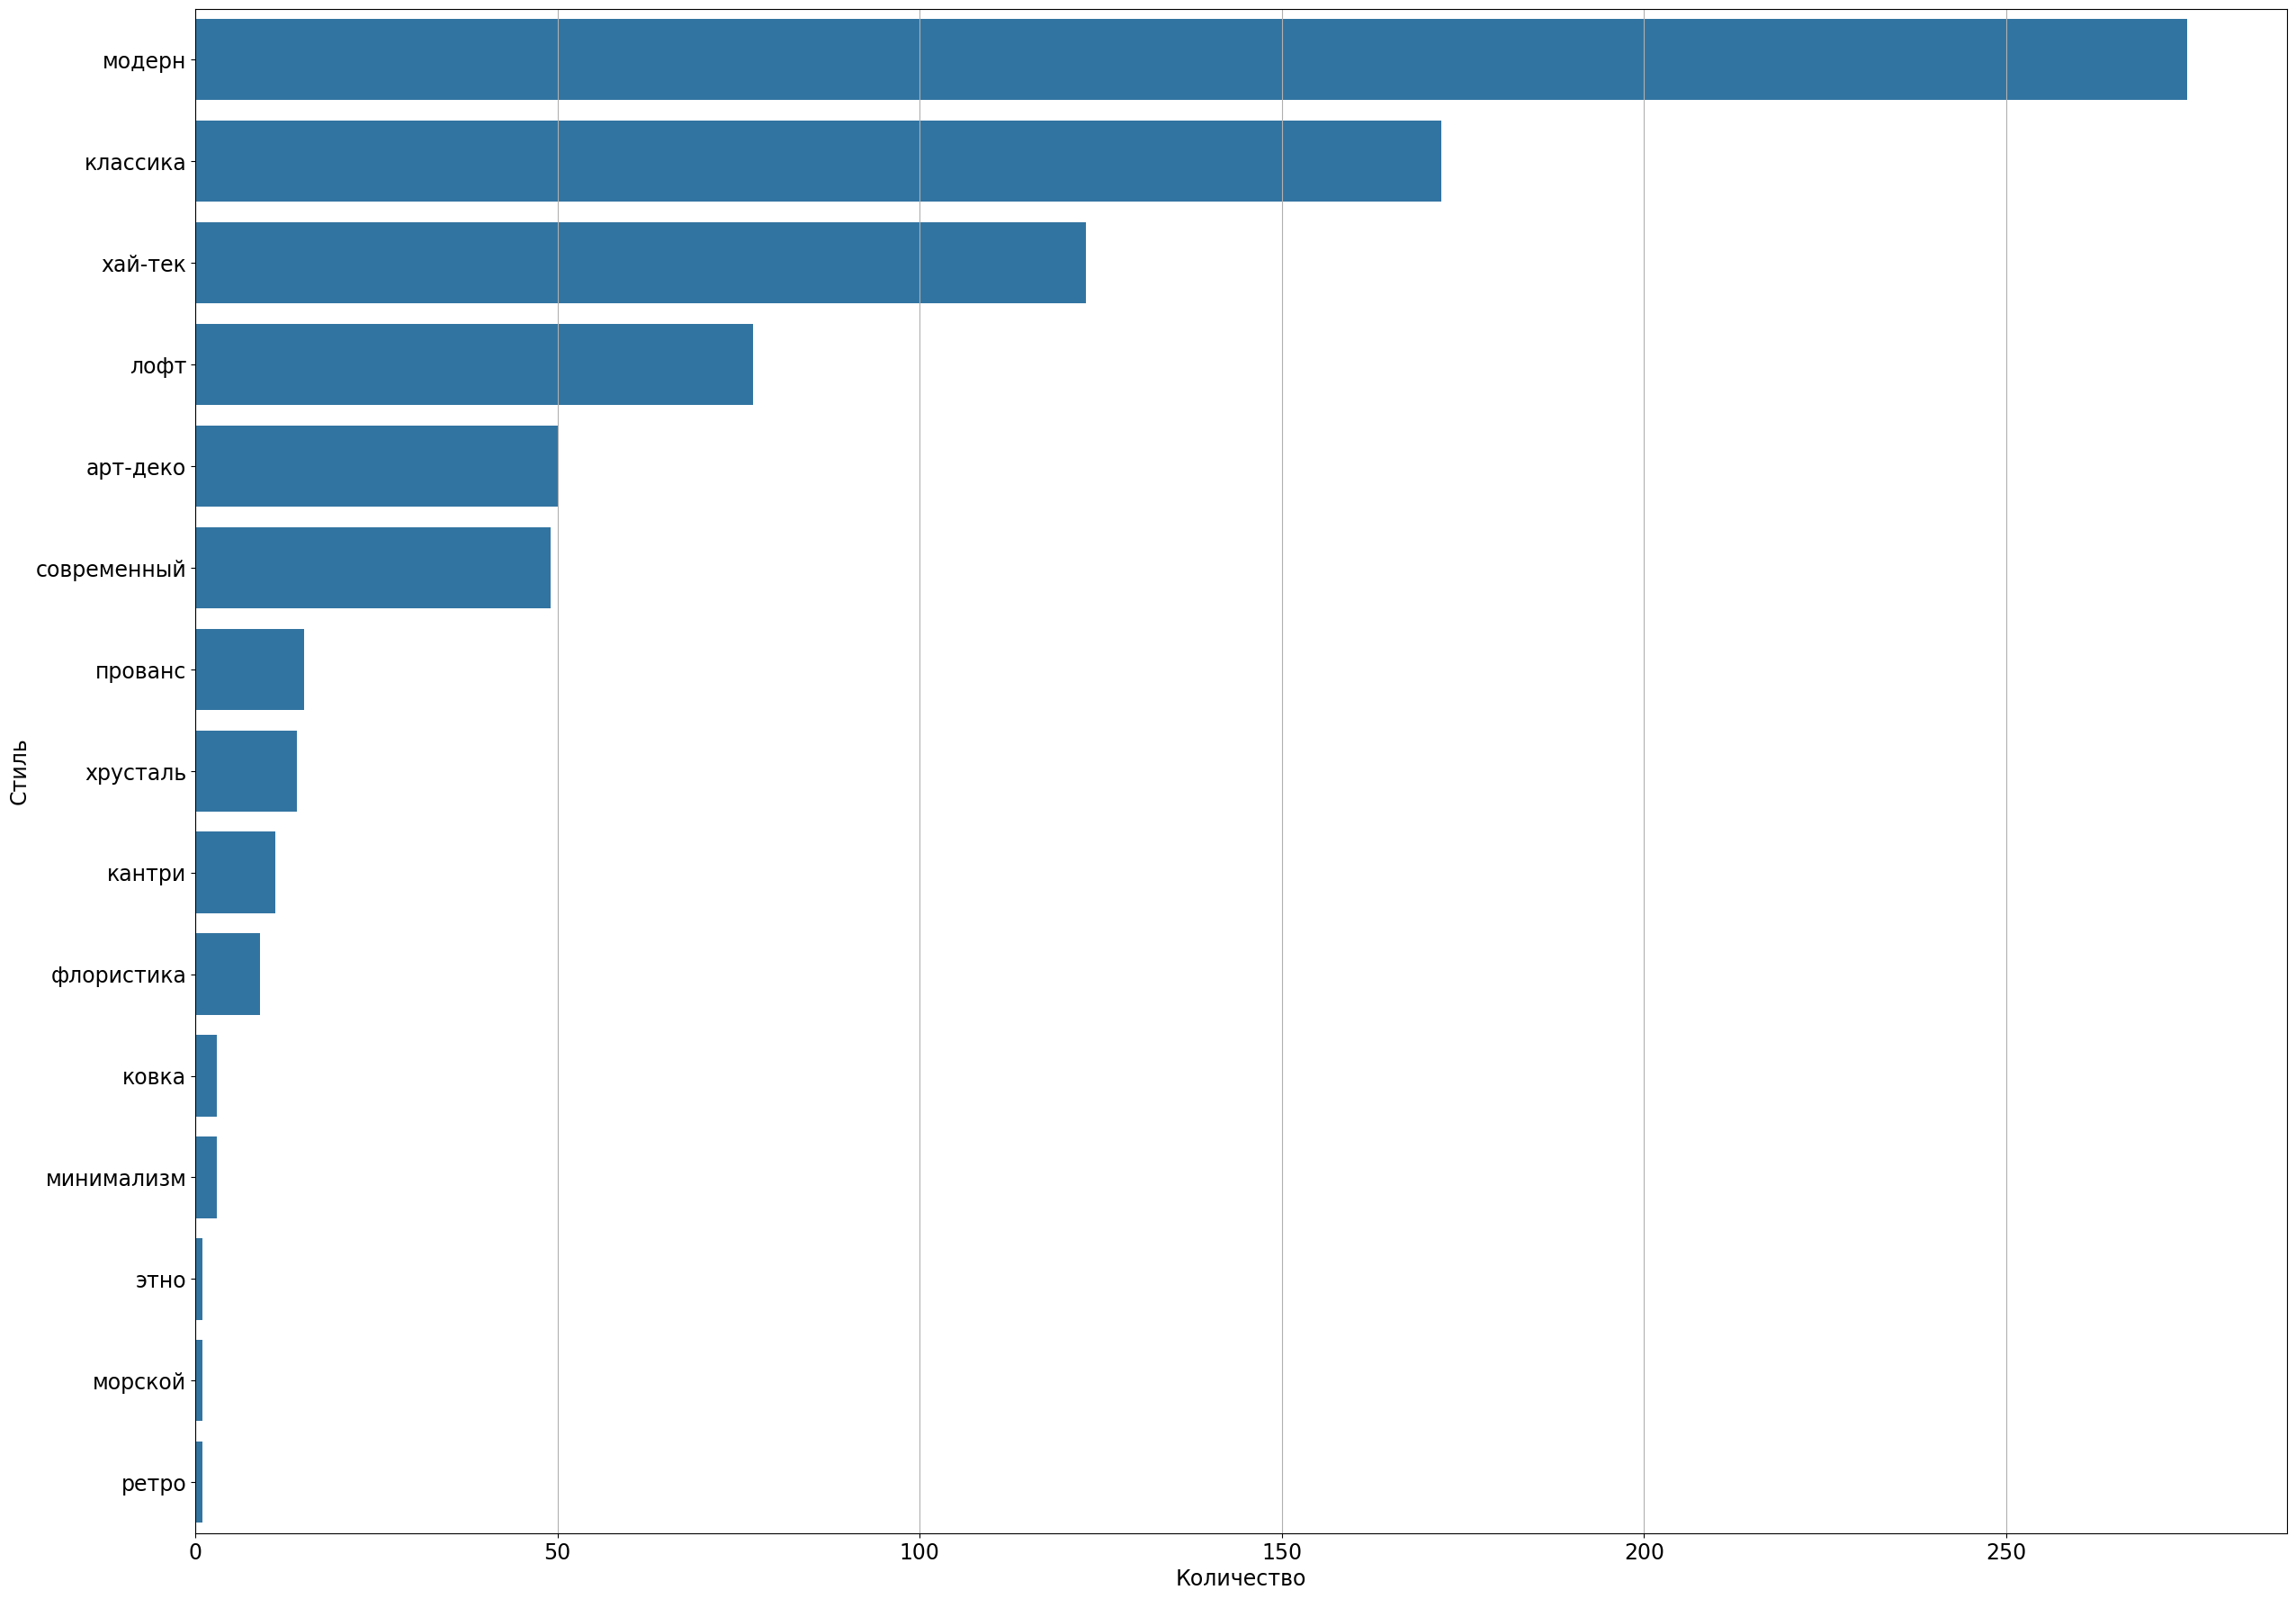

In [101]:
draw_feature_countable("Стиль")

In [102]:
print_feature_counts("Стиль")

модерн 275
классика 172
хай-тек 123
лофт 77
арт-деко 50
современный 49
прованс 15
хрусталь 14
кантри 11
флористика 9
ковка 3
минимализм 3
этно 1
морской 1
ретро 1


In [103]:
remove_all_category_except("Стиль", ["модерн", "хай-тек", "классика", "лофт", "арт-деко", "современный"])

###### Цоколь

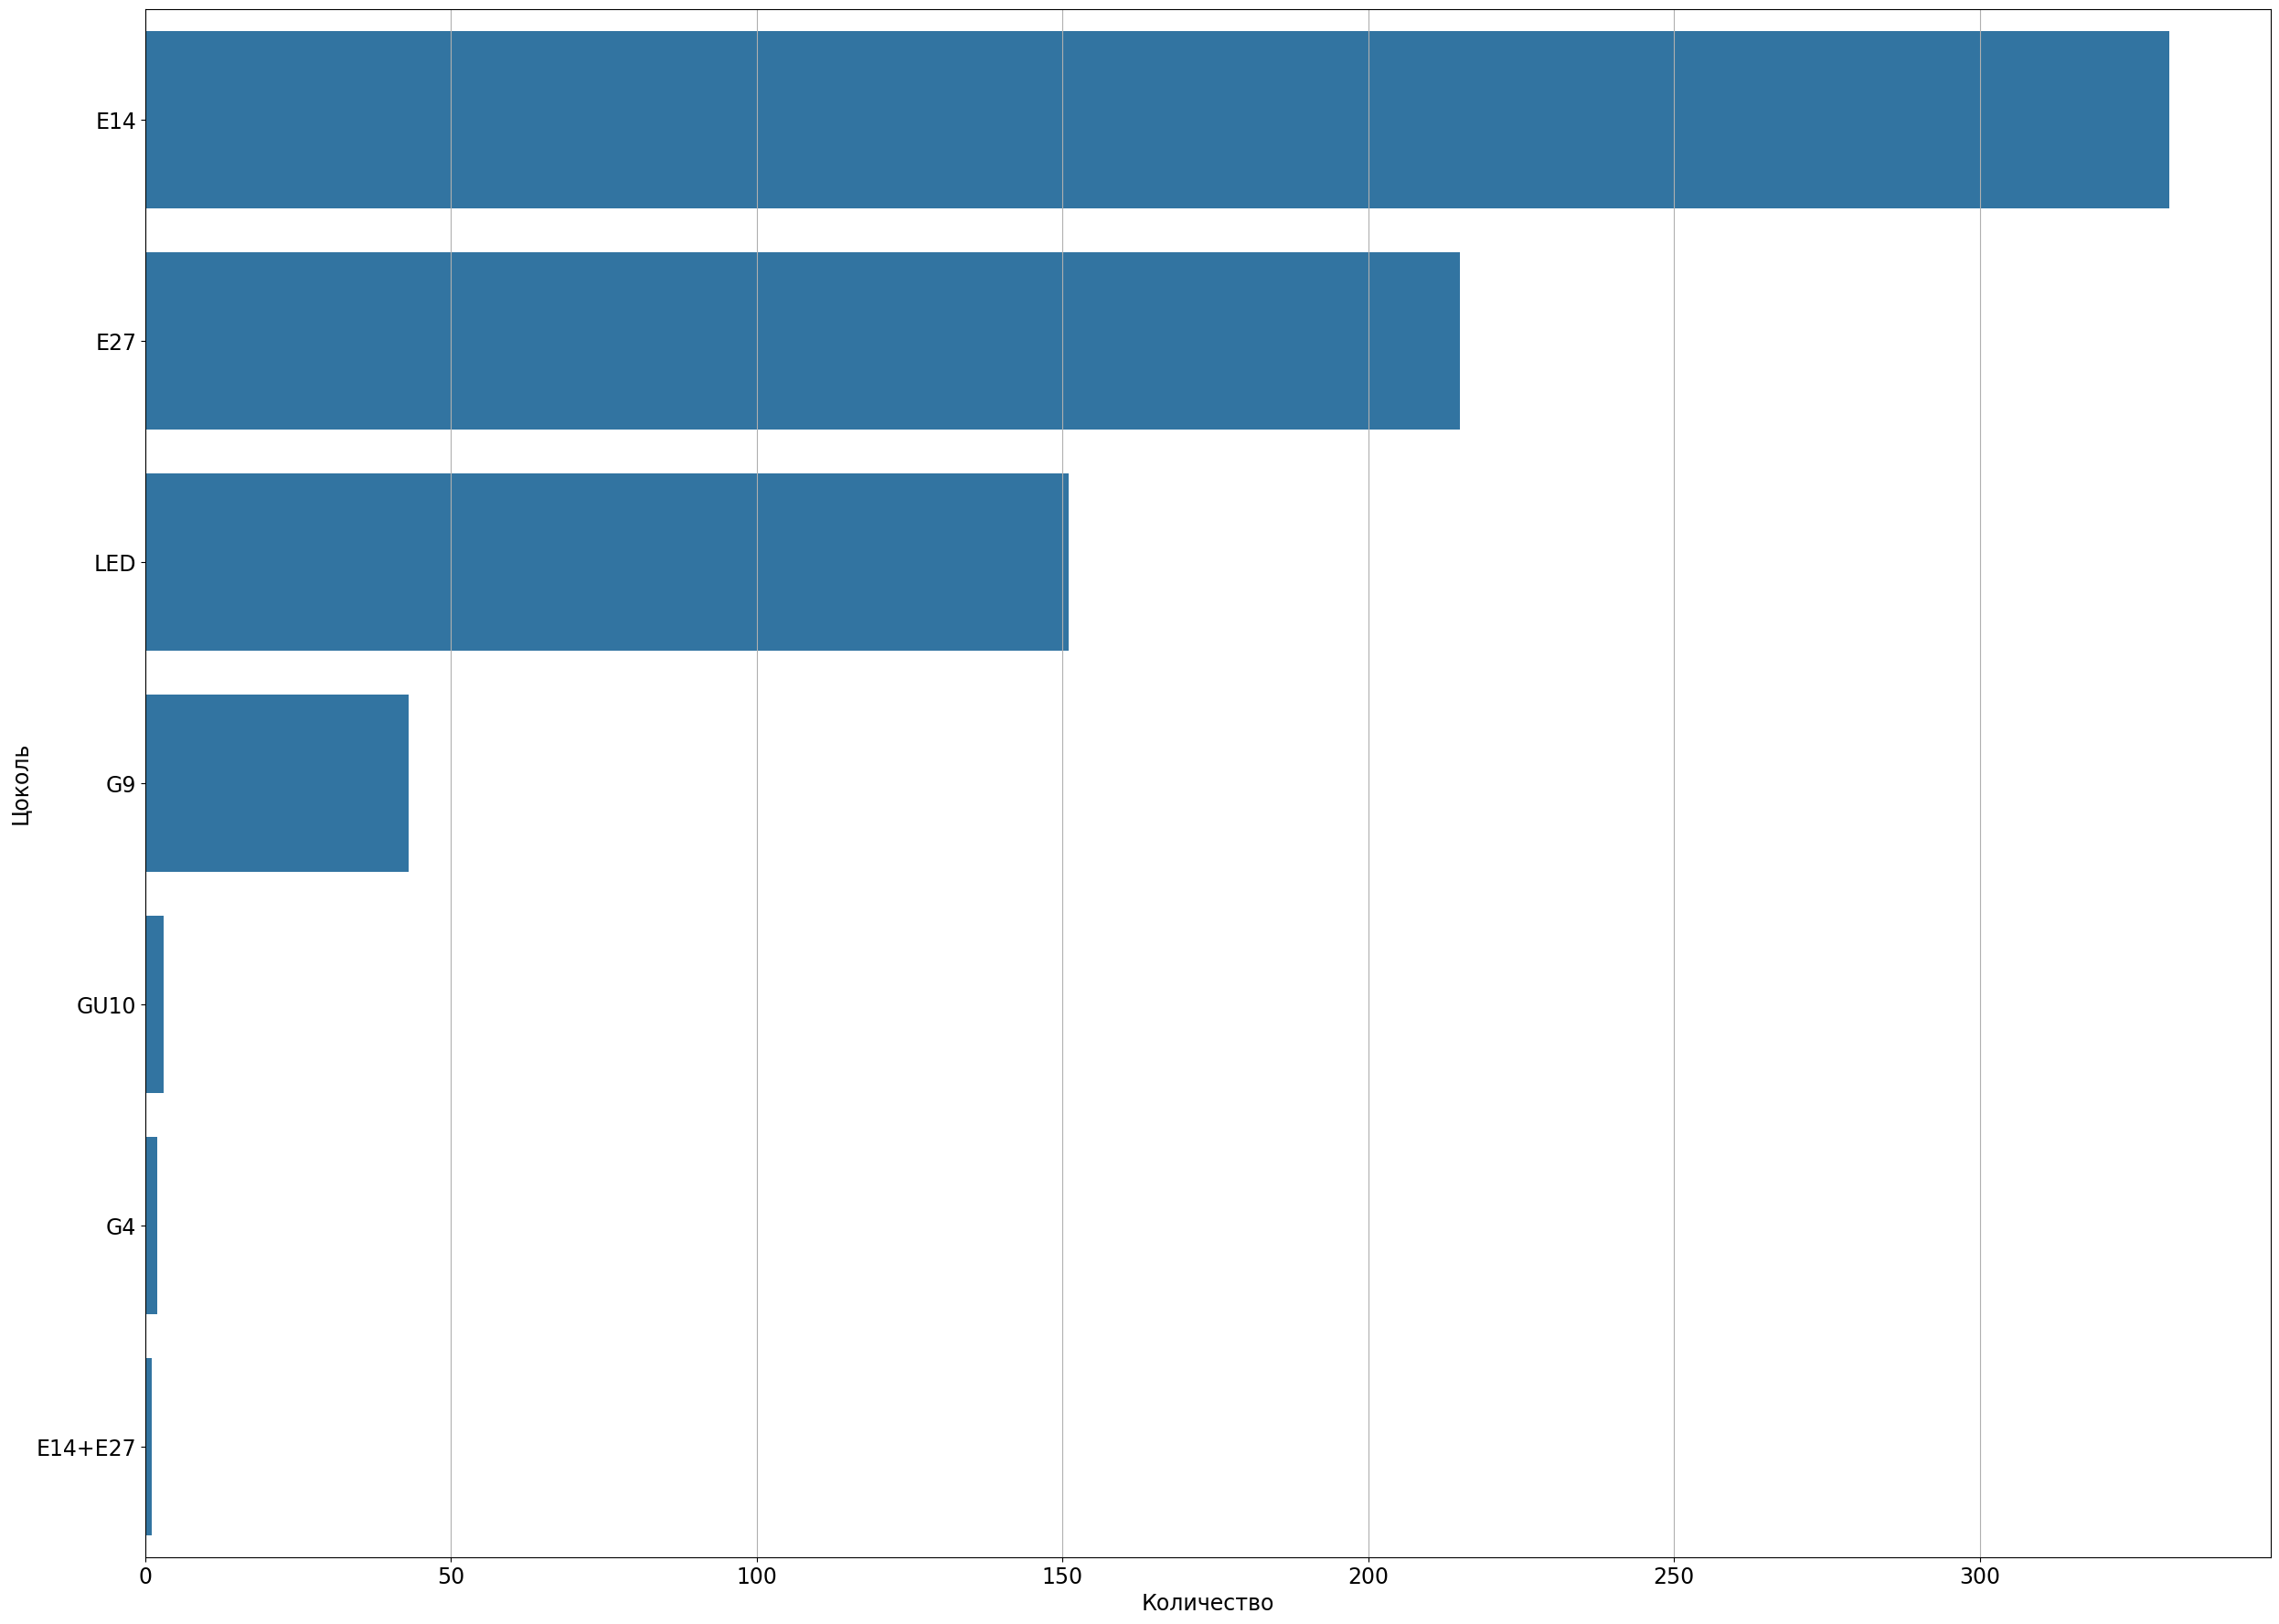

In [104]:
draw_feature_countable("Цоколь")

In [105]:
print_feature_counts("Цоколь")

E14 331
E27 215
LED 151
G9 43
GU10 3
G4 2
E14+E27 1


In [106]:
remove_all_category_except("Цоколь", ["E14", "LED", "E27"])

#### Идентификация и фильтрация выбросов по цене

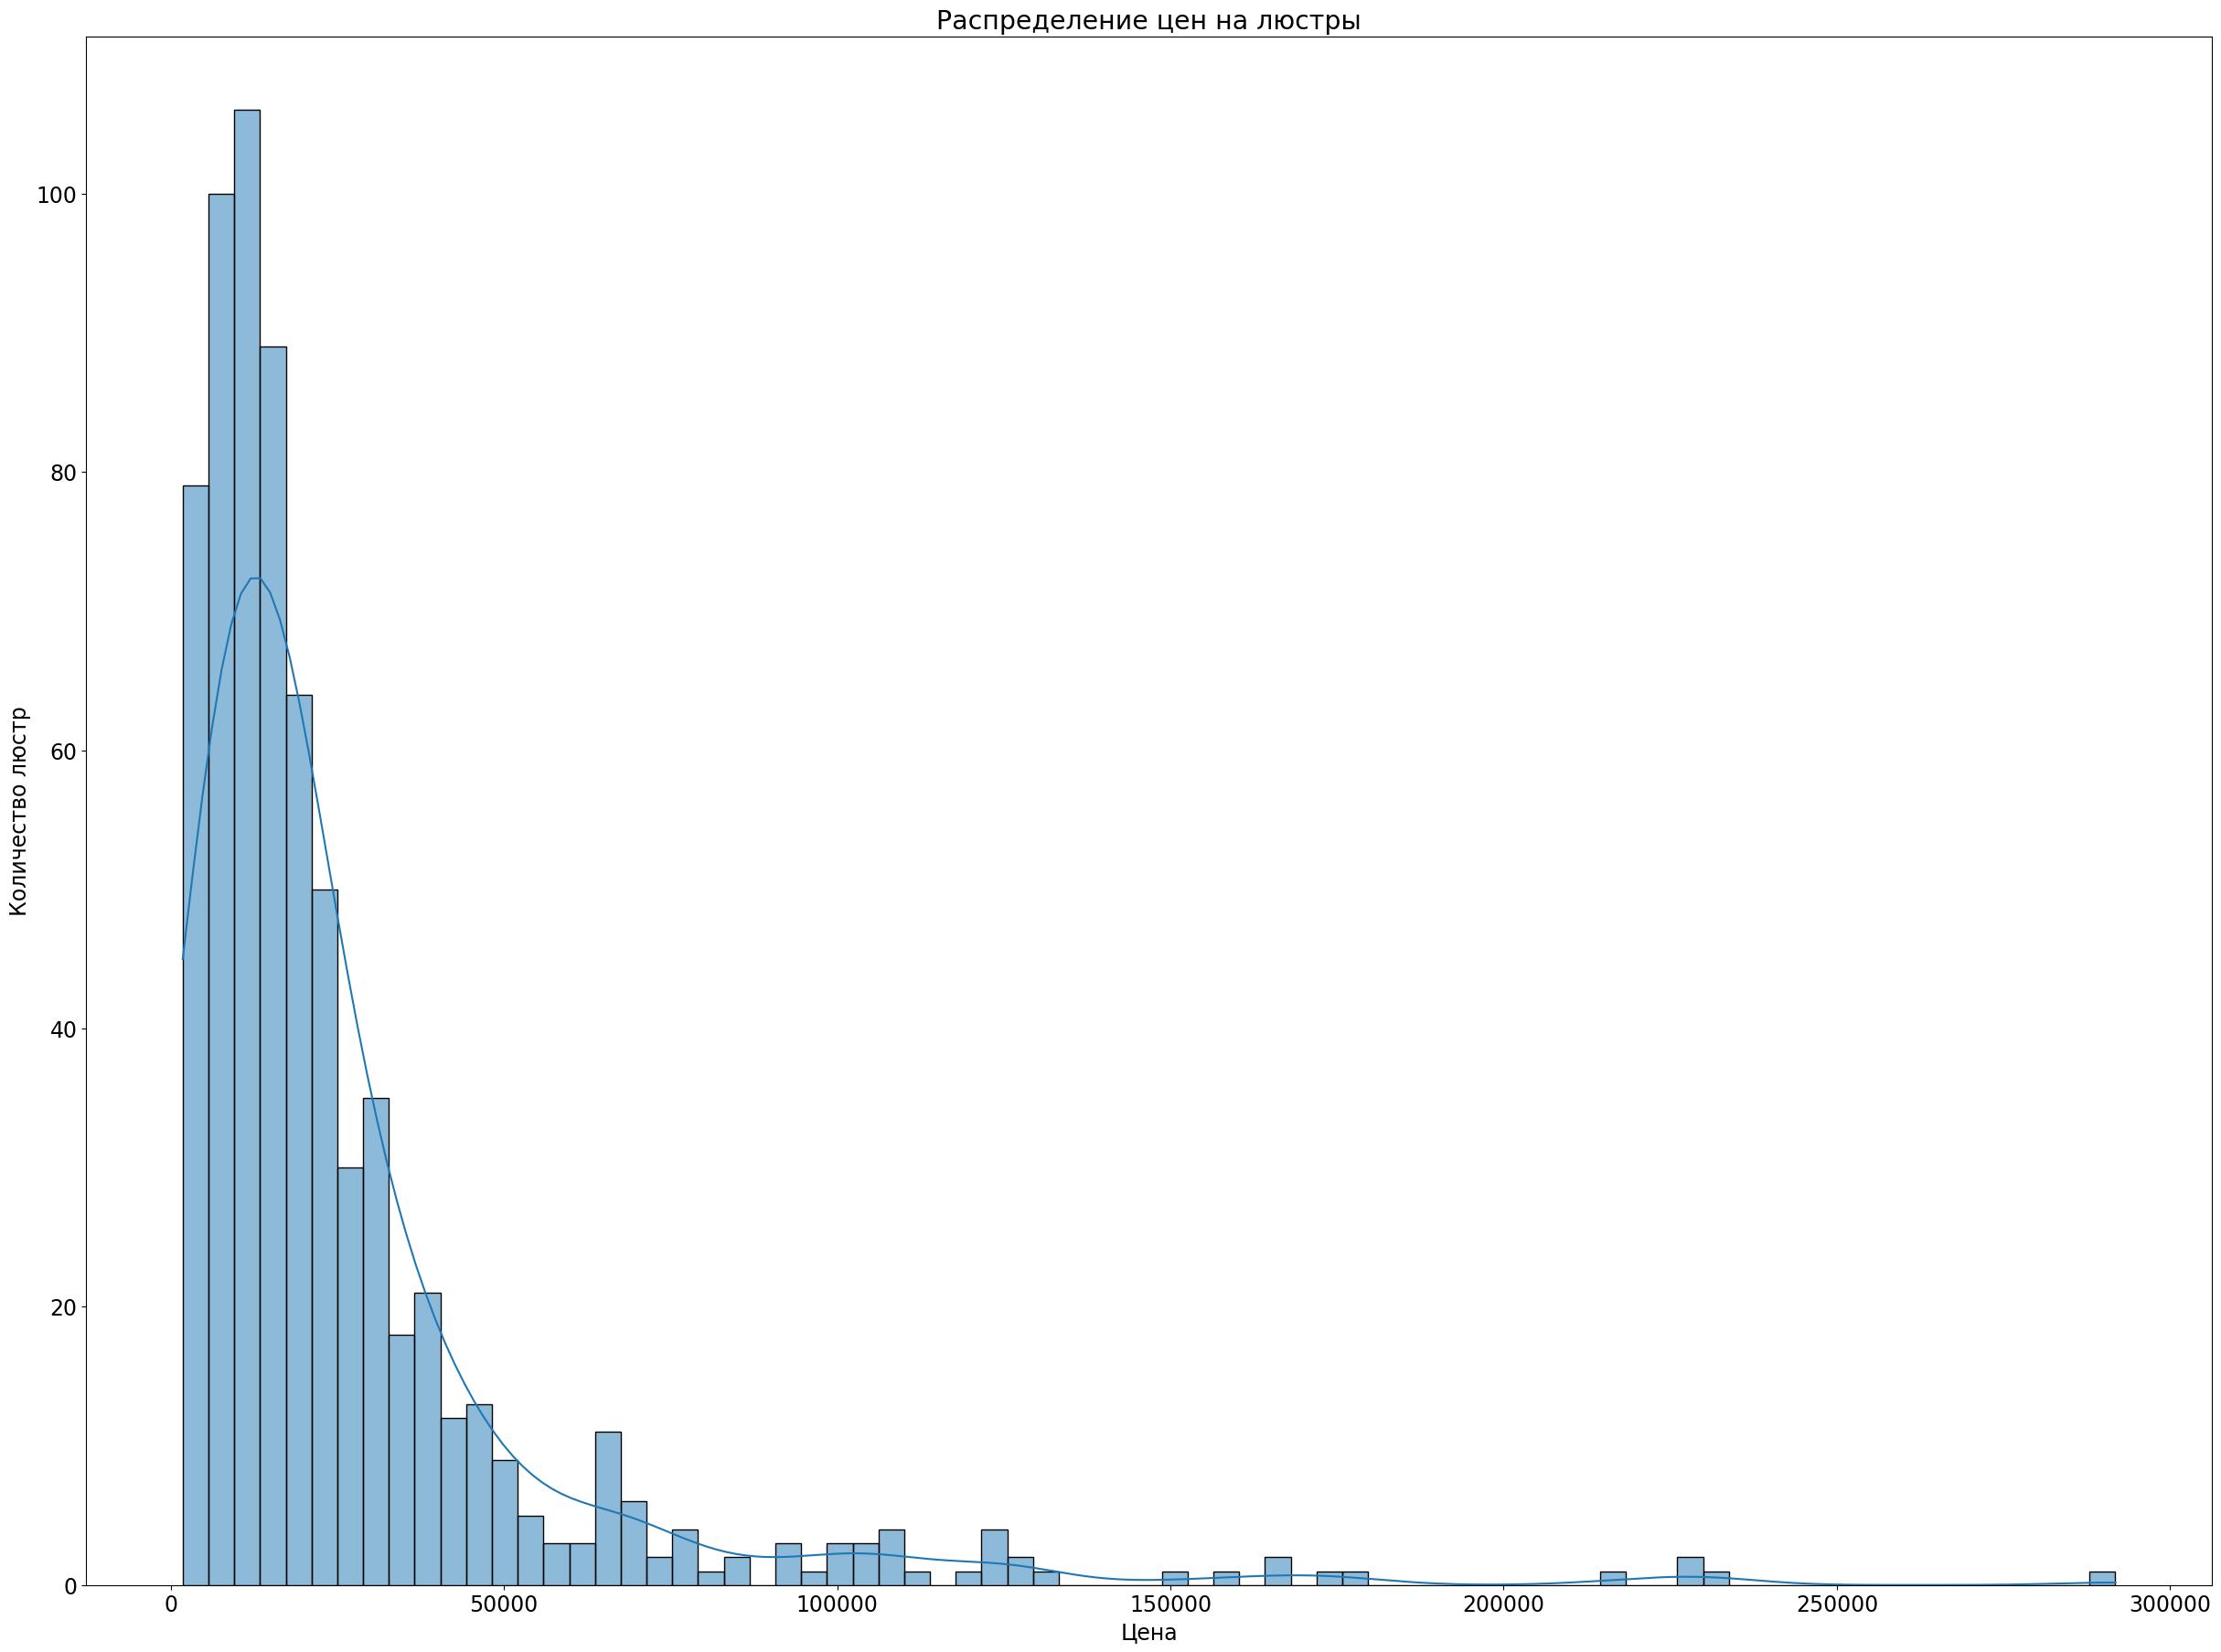

In [107]:
matplotlib.pyplot.figure(figsize = MATPLOTLIB_PYPLOT_FIGSIZE)
seaborn.histplot(chandeliers[FEATURES_RU_EN["Цена"]], bins = 75, kde = True)
matplotlib.pyplot.title('Распределение цен на люстры')
matplotlib.pyplot.xlabel('Цена')
matplotlib.pyplot.ylabel('Количество люстр')
matplotlib.pyplot.show()

In [108]:
q_1 = chandeliers[FEATURES_RU_EN["Цена"]].quantile(0.25)
q_3 = chandeliers[FEATURES_RU_EN["Цена"]].quantile(0.75)
iqr = q_3 - q_1
lower_bound = q_1 - 1.5 * iqr
upper_bound = q_3 + 1.5 * iqr

In [109]:
lower_bound

-20700.0

In [110]:
upper_bound

59300.0

In [111]:
chandeliers = chandeliers[(chandeliers[FEATURES_RU_EN["Цена"]] >= lower_bound) & (chandeliers[FEATURES_RU_EN["Цена"]] <= upper_bound)]

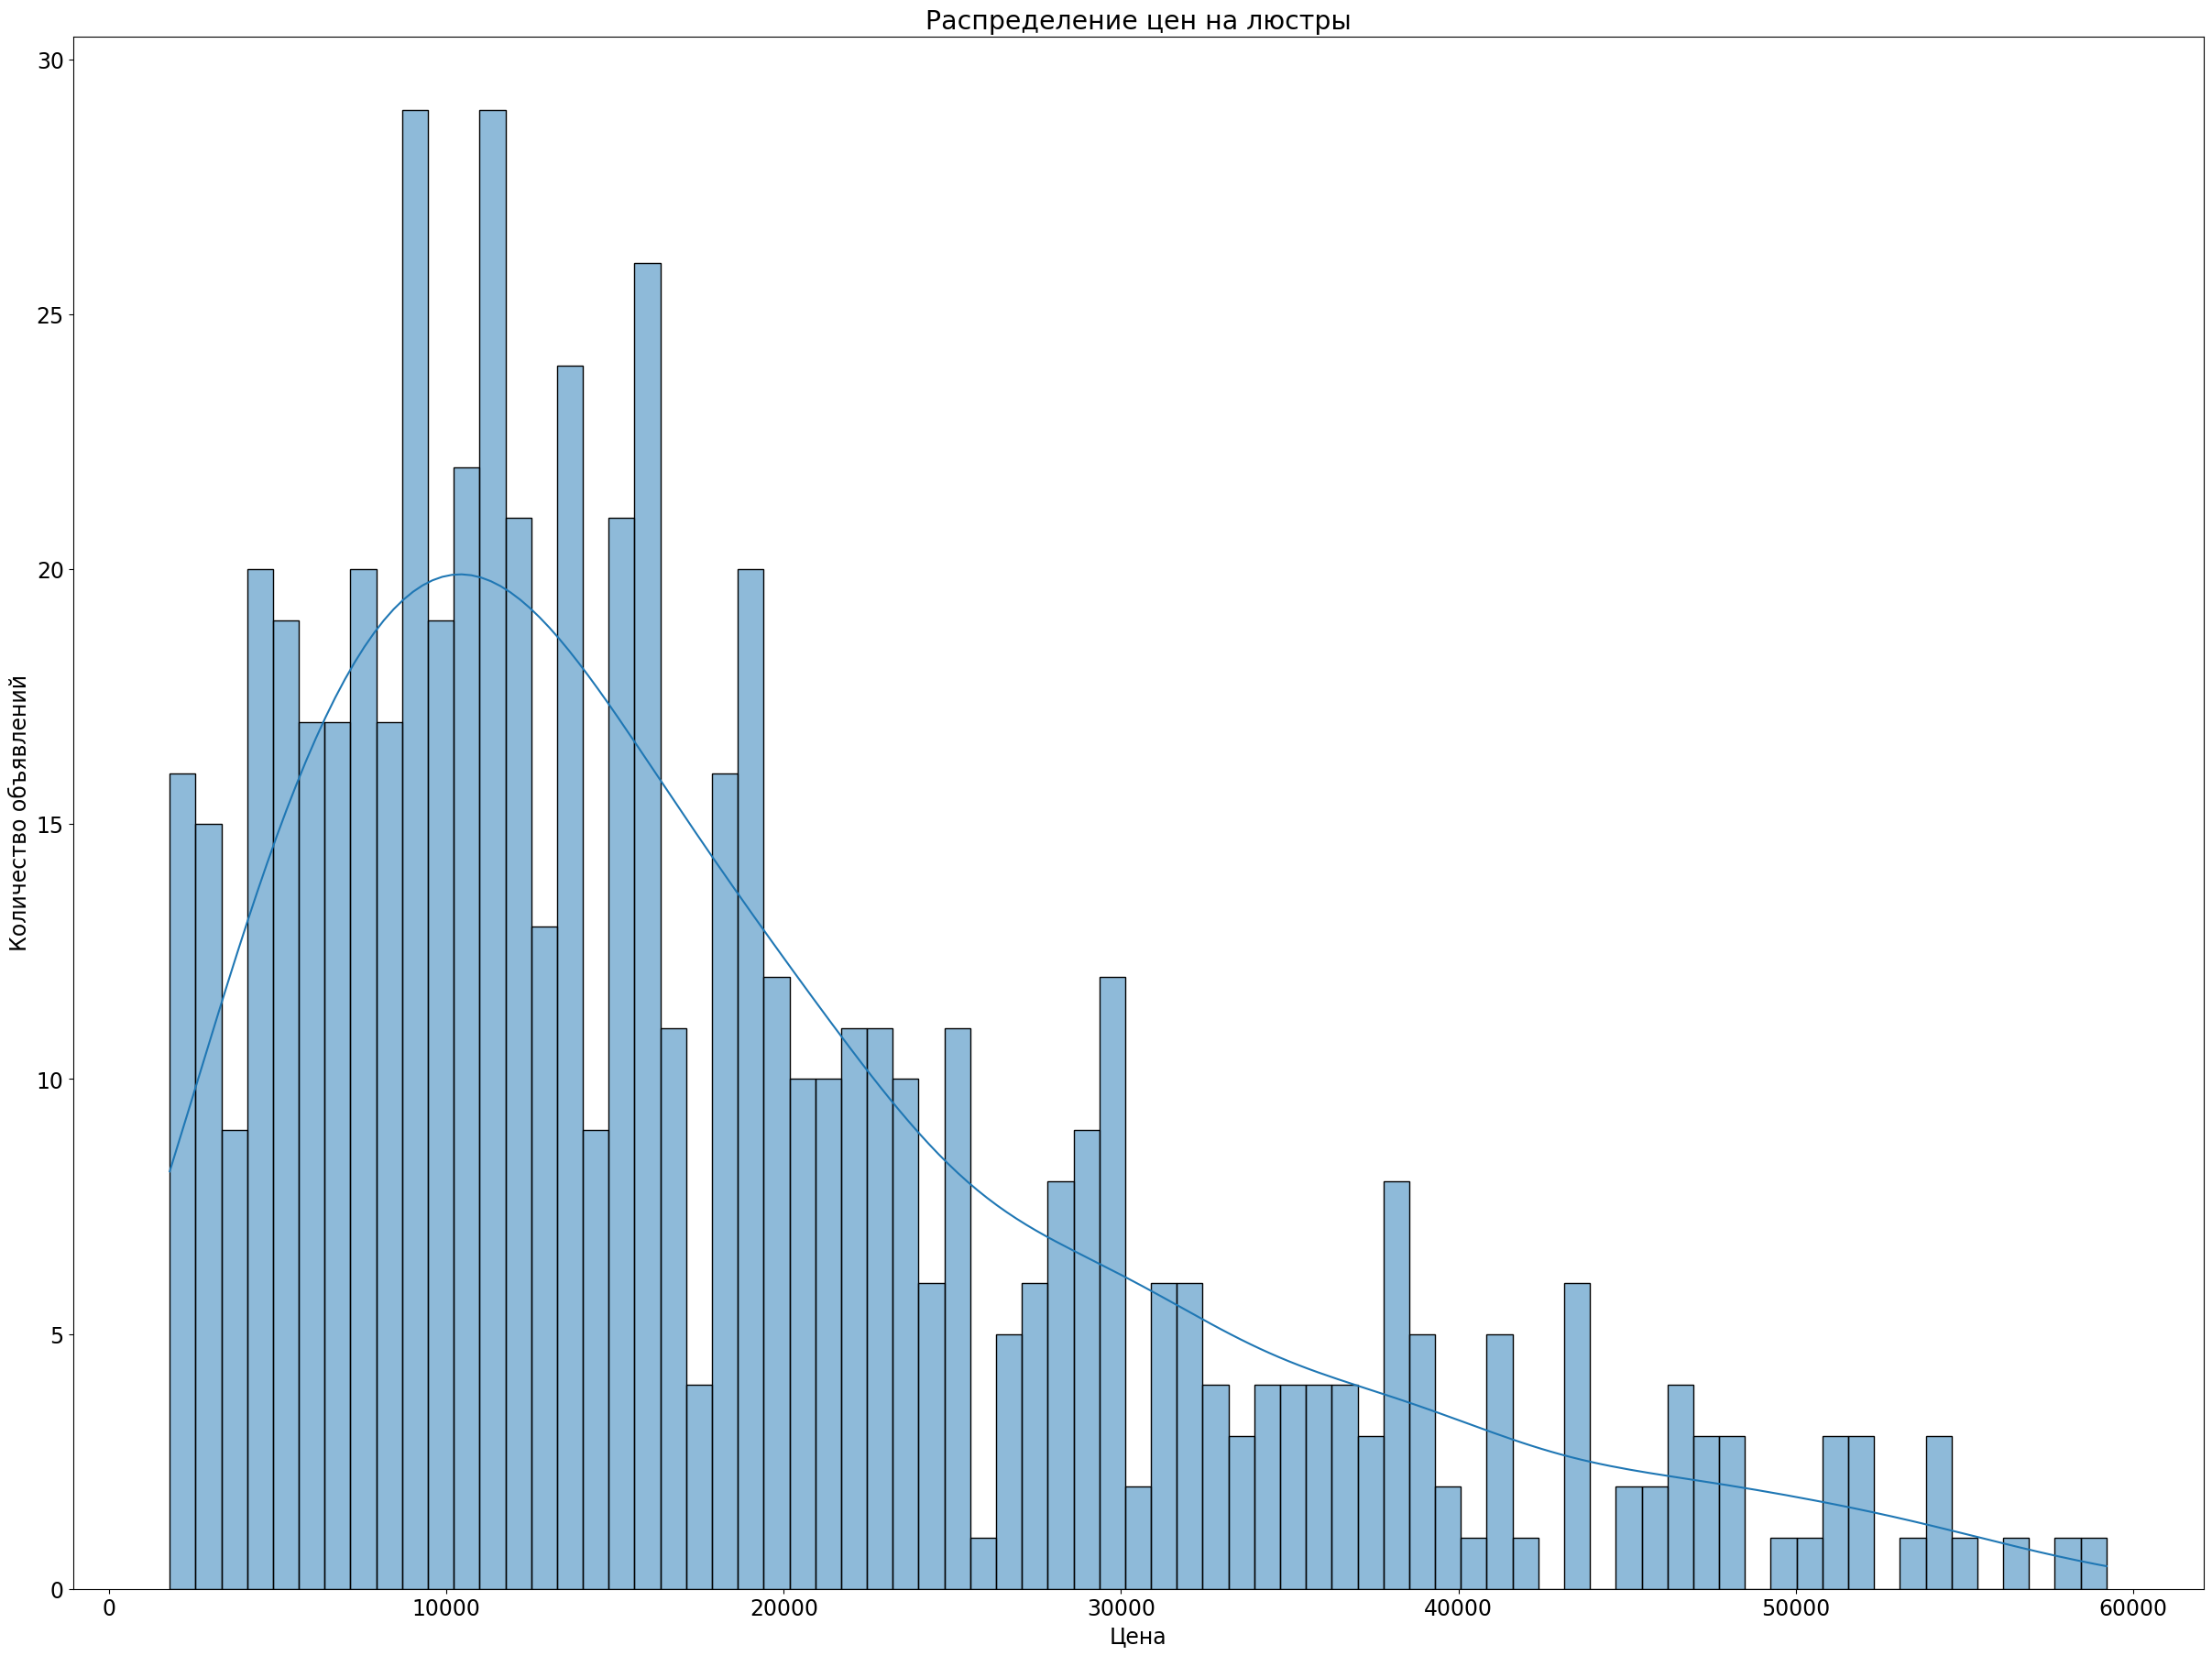

In [112]:
matplotlib.pyplot.figure(figsize = MATPLOTLIB_PYPLOT_FIGSIZE)
seaborn.histplot(chandeliers[FEATURES_RU_EN["Цена"]], bins = 75, kde = True)
matplotlib.pyplot.title('Распределение цен на люстры')
matplotlib.pyplot.xlabel('Цена')
matplotlib.pyplot.ylabel('Количество объявлений')
matplotlib.pyplot.show()

#### Обработанные данные

In [113]:
chandeliers.head()

,price,voltage,brand,diameter,height,color_reinforcement,color_shade,count_lamp,power,general_power,style,plinth
144,9700,220,ST Luce,600.0,230.0,хром,хром,9,40.0,360.0,хай-тек,E14
151,9900,220,ST Luce,375.0,150.0,золото,золото,1,62.0,62.0,хай-тек,LED
652,9410,220,Vitaluce,790.0,385.0,хром,серый,6,40.0,240.0,арт-деко,E14
678,14500,230,ST Luce,600.0,500.0,золото,янтарный,8,40.0,420.0,классика,E14
697,6080,230,Vitaluce,600.0,210.0,черный,серый,5,40.0,200.0,арт-деко,E27


In [114]:
chandeliers.tail()

,price,voltage,brand,diameter,height,color_reinforcement,color_shade,count_lamp,power,general_power,style,plinth
25834,33080,220,Reccagni Angelo,620.0,360.0,золото,бежевый,5,60.0,300.0,классика,E27
25838,48130,220,Reccagni Angelo,540.0,360.0,золото,бежевый,3,60.0,180.0,классика,E27
25876,46480,220,Reccagni Angelo,300.0,170.0,золото,золото,2,60.0,120.0,классика,E27
26119,2560,220,Vitaluce,350.0,145.0,черный,черный,6,40.0,40.0,лофт,E27
26123,8950,220,Vitaluce,720.0,125.0,черный,черный,5,35.0,35.0,хай-тек,LED


### Подготовительный этап

#### Преобразования текстовых значений в числовые

In [115]:
def convert_str2num(num: str):
	avg = num.find("-")
	if avg < 0:
		return numpy.float64(num)
	else:
		nums = num.split("-")
		return (float(nums[0]) + float(nums[1])) / 2

In [116]:
for feat in FEATURES_EN_NUMERIC:
    chandeliers[feat] = chandeliers[feat].apply(lambda x: convert_str2num(x) if isinstance(x, str) else x)

#### Преобразование категориальных переменных в числа

In [117]:
chandeliers_text_categories_indexes = {feat: {c: i for i, c in enumerate(chandeliers[feat].unique())} for feat in FEATURES_EN_TEXT}

In [118]:
chandeliers_text_categories_indexes

{'brand': {'ST Luce': 0,
  'Vitaluce': 1,
  'Arte lamp': 2,
  'Citilux': 3,
  'Eurosvet': 4,
  'Reccagni Angelo': 5},
 'color_reinforcement': {'хром': 0, 'золото': 1, 'черный': 2, 'белый': 3},
 'color_shade': {'хром': 0,
  'золото': 1,
  'серый': 2,
  'янтарный': 3,
  'бежевый': 4,
  'черный': 5},
 'style': {'хай-тек': 0,
  'арт-деко': 1,
  'классика': 2,
  'модерн': 3,
  'лофт': 4,
  'современный': 5},
 'plinth': {'E14': 0, 'LED': 1, 'E27': 2}}

In [119]:
for feat in FEATURES_EN_TEXT:
	if feat == FEATURES_RU_EN[TARGET_PREDICT]:
		continue
	chandeliers[feat].replace(to_replace = chandeliers_text_categories_indexes[feat], inplace = True)

/tmp/ipykernel_17848/3416184113.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  chandeliers[feat].replace(to_replace = chandeliers_text_categories_indexes[feat], inplace = True)
/tmp/ipykernel_17848/3416184113.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  chandeliers[feat].replace(to_repla

#### Обработанные данные

In [120]:
chandeliers.head()

,price,voltage,brand,diameter,height,color_reinforcement,color_shade,count_lamp,power,general_power,style,plinth
144,9700,220.0,ST Luce,600.0,230.0,0,0,9,40.0,360.0,0,0
151,9900,220.0,ST Luce,375.0,150.0,1,1,1,62.0,62.0,0,1
652,9410,220.0,Vitaluce,790.0,385.0,0,2,6,40.0,240.0,1,0
678,14500,230.0,ST Luce,600.0,500.0,1,3,8,40.0,420.0,2,0
697,6080,230.0,Vitaluce,600.0,210.0,2,2,5,40.0,200.0,1,2


In [121]:
chandeliers.tail()

,price,voltage,brand,diameter,height,color_reinforcement,color_shade,count_lamp,power,general_power,style,plinth
25834,33080,220.0,Reccagni Angelo,620.0,360.0,1,4,5,60.0,300.0,2,2
25838,48130,220.0,Reccagni Angelo,540.0,360.0,1,4,3,60.0,180.0,2,2
25876,46480,220.0,Reccagni Angelo,300.0,170.0,1,1,2,60.0,120.0,2,2
26119,2560,220.0,Vitaluce,350.0,145.0,2,5,6,40.0,40.0,4,2
26123,8950,220.0,Vitaluce,720.0,125.0,2,5,5,35.0,35.0,0,1


### Разделение на `train`, `test`

In [122]:
target: List[numpy.array] = []
features: List[str] = []

In [123]:
for _, row in chandeliers.iterrows():
	collected_targets: List[float] = []
	for feat in FEATURES_EN_ALL:
		if feat == FEATURES_RU_EN[TARGET_PREDICT]:
			features.append(row[feat])
		else:
			collected_targets.append(row[feat])
	target.append(numpy.array(collected_targets))

In [124]:
y_train, y_test, X_train, X_test = sklearn.model_selection.train_test_split(features, target, test_size = 0.3, random_state = 42)

### Демонстрация работоспособности

#### Первый запуск

In [125]:
model = MyKNearestNeighborClassifier(distance_euclidean, kernel_uniform, False)

In [126]:
model.fit(X_train, y_train)

In [127]:
pred = [model.predict(item) for item in X_test]
expected = len(y_test)
actual = 0
for i in range(len(y_test)):
	if y_test[i] == pred[i]:
		actual += 1

In [128]:
print("Accuracy is %d%% where %d/%d" % (((actual / expected) * 100), actual, expected))

Accuracy is 32% where 63/191


#### Подбор параметров

In [129]:
study = optuna.create_study(direction = "minimize")

[I 2024-03-28 23:02:42,148] A new study created in memory with name: no-name-e96b67b6-0b81-4fc1-9ec2-2f104bbaeda7


In [130]:
def choose_function(func_name: str) -> callable:
	match func_name:
		case "uniform": return kernel_uniform
		case "triangular": return kernel_triangular
		case "epanechnikov": return kernel_epanechnikov
		case "gaussian": return kernel_gaussian
		case "cosine": return distance_cosine
		case "euclidean": return distance_euclidean
		case "manhattan": return distance_manhattan
		case "chebyshev": return distance_chebyshev
		case _: raise ValueError("No callable was found by function name.")

In [131]:
def objective(trial: optuna.Trial) -> numpy.float64:
	kernel_fn = trial.suggest_categorical("kernel", ["uniform", "triangular", "epanechnikov", "gaussian"])
	distance_fn = trial.suggest_categorical("distance", ["cosine", "euclidean", "manhattan"])
	k_neighbor = trial.suggest_int("k_neighbor", 5, 10, log = True)
	radius = trial.suggest_float("radius", 1.0, 5.0, step = 0.1)
	is_fixed_window = trial.suggest_categorical("is_fixed_window", [True, False])

	ERROR_MAXIMUM: numpy.float64 = 1.0

	model: MyKNearestNeighborClassifier = None
	if is_fixed_window:
		model = MyKNearestNeighborClassifier(choose_function(distance_fn), choose_function(kernel_fn), True, radius = radius)
	else:
		model = MyKNearestNeighborClassifier(choose_function(distance_fn), choose_function(kernel_fn), False, k_neighbor = k_neighbor)

	model.fit(X_train, y_train)
	pred = [model.predict(item) for item in X_test]
	for p in pred:
		if p is None:
			return ERROR_MAXIMUM
	expected = len(y_test)
	actual = 0
	for i in range(expected):
		if y_test[i] == pred[i]:
			actual += 1
	accuracy = actual / expected
	error = ERROR_MAXIMUM - accuracy
	return error

In [132]:
study.optimize(objective, n_trials = OPTUNA_STUDY_N_TRIALS)

[I 2024-03-28 23:02:42,396] Trial 0 finished with value: 1.0 and parameters: {'kernel': 'triangular', 'distance': 'manhattan', 'k_neighbor': 7, 'radius': 4.5, 'is_fixed_window': True}. Best is trial 0 with value: 1.0.


[I 2024-03-28 23:02:42,635] Trial 1 finished with value: 0.6282722513089005 and parameters: {'kernel': 'epanechnikov', 'distance': 'cosine', 'k_neighbor': 6, 'radius': 2.8, 'is_fixed_window': True}. Best is trial 1 with value: 0.6282722513089005.
[I 2024-03-28 23:02:42,928] Trial 2 finished with value: 0.7905759162303665 and parameters: {'kernel': 'triangular', 'distance': 'manhattan', 'k_neighbor': 10, 'radius': 2.8, 'is_fixed_window': False}. Best is trial 1 with value: 0.6282722513089005.
[I 2024-03-28 23:02:43,183] Trial 3 finished with value: 0.5968586387434556 and parameters: {'kernel': 'triangular', 'distance': 'cosine', 'k_neighbor': 8, 'radius': 3.1, 'is_fixed_window': False}. Best is trial 3 with value: 0.5968586387434556.
[I 2024-03-28 23:02:43,418] Trial 4 finished with value: 0.7905759162303665 and parameters: {'kernel': 'triangular', 'distance': 'manhattan', 'k_neighbor': 7, 'radius': 4.300000000000001, 'is_fixed_window': False}. Best is trial 3 with value: 0.596858638743

In [133]:
study.best_params

{'kernel': 'gaussian',
 'distance': 'cosine',
 'k_neighbor': 10,
 'radius': 2.1,
 'is_fixed_window': False}

In [135]:
print("Minimum best error:", study.best_value)

Minimum best error: 0.581151832460733


#### Исследование в зависимости от количества соседей

In [136]:
k_neighbors = range(1, 30)

In [137]:
def draw_errors(errors_train, errors_test, errors_train_library, errors_test_library, params):
	title = "Исследование ошибки от гиперпараметра"
	xlabel = "Гиперпараметр k_neighbor"
	ylabel = "Ошибка предсказания"
	matplotlib.pyplot.figure(figsize = MATPLOTLIB_PYPLOT_FIGSIZE)
	matplotlib.pyplot.title(title)
	matplotlib.pyplot.plot(params, errors_train, color = COLOR_SET_TRAIN, label = "Множество TRAIN")
	matplotlib.pyplot.plot(params, errors_test, color = COLOR_SET_TEST, label = "Множество TEST")
	matplotlib.pyplot.plot(params, errors_train_library, color = COLOR_SET_TRAIN_LIBRARY, label = "Множество TRAIN на библиотечной реализации")
	matplotlib.pyplot.plot(params, errors_test_library, color = COLOR_SET_TEST_LIBRARY, label = "Множество TEST на библиотечной реализации")
	matplotlib.pyplot.xlabel(xlabel)
	matplotlib.pyplot.ylabel(ylabel)
	matplotlib.pyplot.legend()
	matplotlib.pyplot.show()

In [138]:
def draw_accuracy(errors_train, errors_test, errors_train_library, errors_test_library, params):
	title = "Исследование точности от гиперпараметра"
	xlabel = "Гиперпараметр k_neighbor"
	ylabel = "Точность предсказания"
	matplotlib.pyplot.figure(figsize = MATPLOTLIB_PYPLOT_FIGSIZE)
	matplotlib.pyplot.title(title)
	matplotlib.pyplot.plot(params, errors_train, color = COLOR_SET_TRAIN, label = "Множество TRAIN")
	matplotlib.pyplot.plot(params, errors_test, color = COLOR_SET_TEST, label = "Множество TEST")
	matplotlib.pyplot.plot(params, errors_train_library, color = COLOR_SET_TRAIN_LIBRARY, label = "Множество TRAIN на библиотечной реализации")
	matplotlib.pyplot.plot(params, errors_test_library, color = COLOR_SET_TEST_LIBRARY, label = "Множество TEST на библиотечной реализации")
	matplotlib.pyplot.xlabel(xlabel)
	matplotlib.pyplot.ylabel(ylabel)
	matplotlib.pyplot.legend()
	matplotlib.pyplot.show()

In [139]:
def get_errors(y_train: List[str], X_train: List[numpy.array], y_test: List[str], X_test: List[numpy.array], k_neighbor: int) -> numpy.float64:
	model = MyKNearestNeighborClassifier(distance_cosine, kernel_gaussian, False, k_neighbor = k_neighbor)
	model.fit(X_train, y_train)
	ERROR_MAXIMUM: numpy.float64 = 1.0
	pred = [model.predict(item) for item in X_test]
	for p in pred:
		if p is None:
			return ERROR_MAXIMUM
	expected = len(y_test)
	actual = 0
	for i in range(len(y_test)):
		if y_test[i] == pred[i]:
			actual += 1
	accuracy = actual / expected
	error = ERROR_MAXIMUM - accuracy
	return error

In [140]:
def get_accuracy(y_train: List[str], X_train: List[numpy.array], y_test: List[str], X_test: List[numpy.array], k_neighbor: int) -> numpy.float64:
	model = MyKNearestNeighborClassifier(distance_cosine, kernel_gaussian, False, k_neighbor = k_neighbor)
	model.fit(X_train, y_train)
	ERROR_MAXIMUM: numpy.float64 = 0
	pred = [model.predict(item) for item in X_test]
	for p in pred:
		if p is None:
			return 0
	expected = len(y_test)
	actual = 0
	for i in range(len(y_test)):
		if y_test[i] == pred[i]:
			actual += 1
	accuracy = actual / expected
	return accuracy

In [141]:
def get_lib_errors(y_train: List[str], X_train: List[numpy.array], y_test: List[str], X_test: List[numpy.array], k_neighbor: int) -> numpy.float64:
	model = MyKNearestNeighborWrapper(k_neighbor, distance_fn = "cosine")
	model.fit(X_train, y_train)
	pred = model.predict(X_test)
	expected = len(pred)
	actual = 0
	for i in range(len(y_test)):
		if y_test[i] == pred[i]:
			actual += 1
	accuracy = actual / expected
	return 1 - accuracy

In [142]:
def get_lib_accuracy(y_train: List[str], X_train: List[numpy.array], y_test: List[str], X_test: List[numpy.array], k_neighbor: int) -> numpy.float64:
	model = MyKNearestNeighborWrapper(k_neighbor, distance_fn = "cosine")
	model.fit(X_train, y_train)
	pred = model.predict(X_test)
	expected = len(pred)
	actual = 0
	for i in range(len(y_test)):
		if y_test[i] == pred[i]:
			actual += 1
	accuracy = actual / expected
	return accuracy

In [143]:
errors_train = []
errors_test = []
errors_train_library = []
errors_test_library = []
accuracy_train = []
accuracy_test = []
accuracy_train_library = []
accuracy_test_library = []

In [144]:
y_train_library = []
y_test_library = []
for y in y_train:
	y_train_library.append(chandeliers_text_categories_indexes[FEATURES_RU_EN[TARGET_PREDICT]][y])
for y in y_test:
	y_test_library.append(chandeliers_text_categories_indexes[FEATURES_RU_EN[TARGET_PREDICT]][y])

In [145]:
for k in tqdm.tqdm(k_neighbors):
	errors_train.append(get_errors(y_train, X_train, y_train, X_train, k))
	errors_test.append(get_errors(y_train, X_train, y_test, X_test, k))
	errors_train_library.append(get_lib_errors(y_train_library, X_train, y_train_library, X_train, k))
	errors_test_library.append(get_lib_errors(y_train_library, X_train, y_test_library, X_test, k))

100%|██████████| 29/29 [00:27<00:00,  1.06it/s]


In [146]:
for k in tqdm.tqdm(k_neighbors):
	accuracy_train.append(get_accuracy(y_train, X_train, y_train, X_train, k))
	accuracy_test.append(get_accuracy(y_train, X_train, y_test, X_test, k))
	accuracy_train_library.append(get_lib_accuracy(y_train_library, X_train, y_train_library, X_train, k))
	accuracy_test_library.append(get_lib_accuracy(y_train_library, X_train, y_test_library, X_test, k))

100%|██████████| 29/29 [00:26<00:00,  1.08it/s]


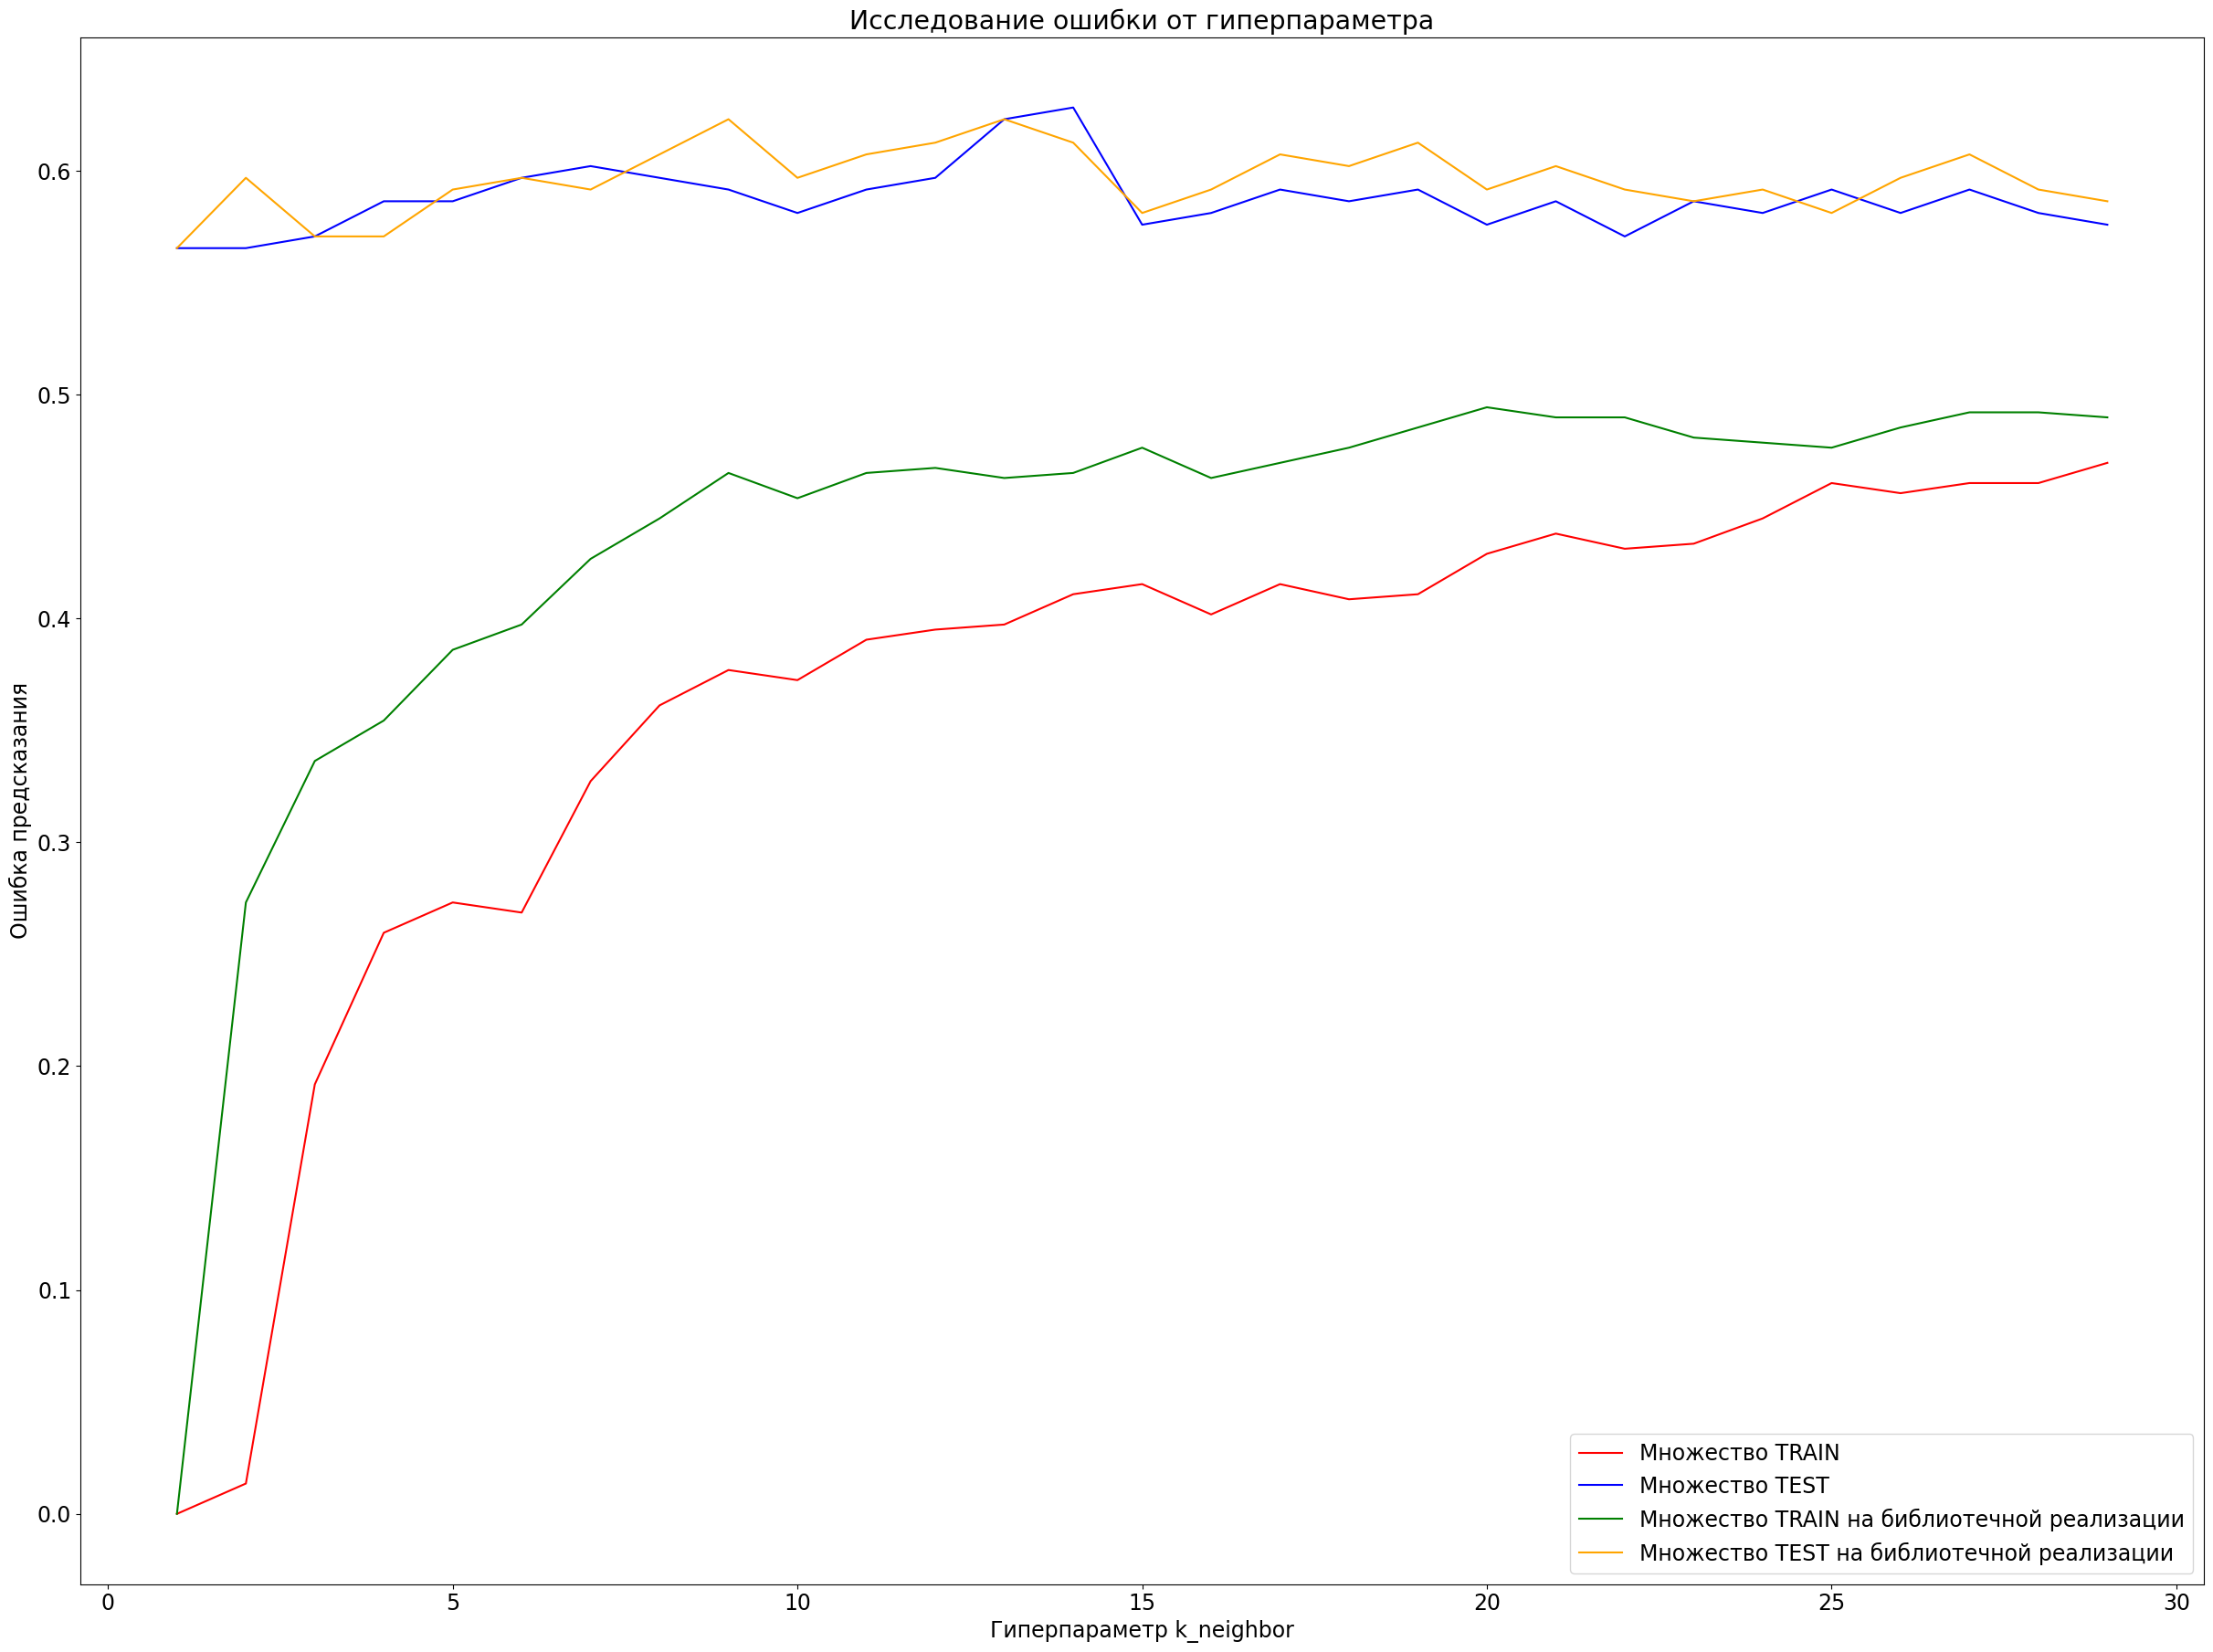

In [147]:
draw_errors(errors_train, errors_test, errors_train_library, errors_test_library, k_neighbors)

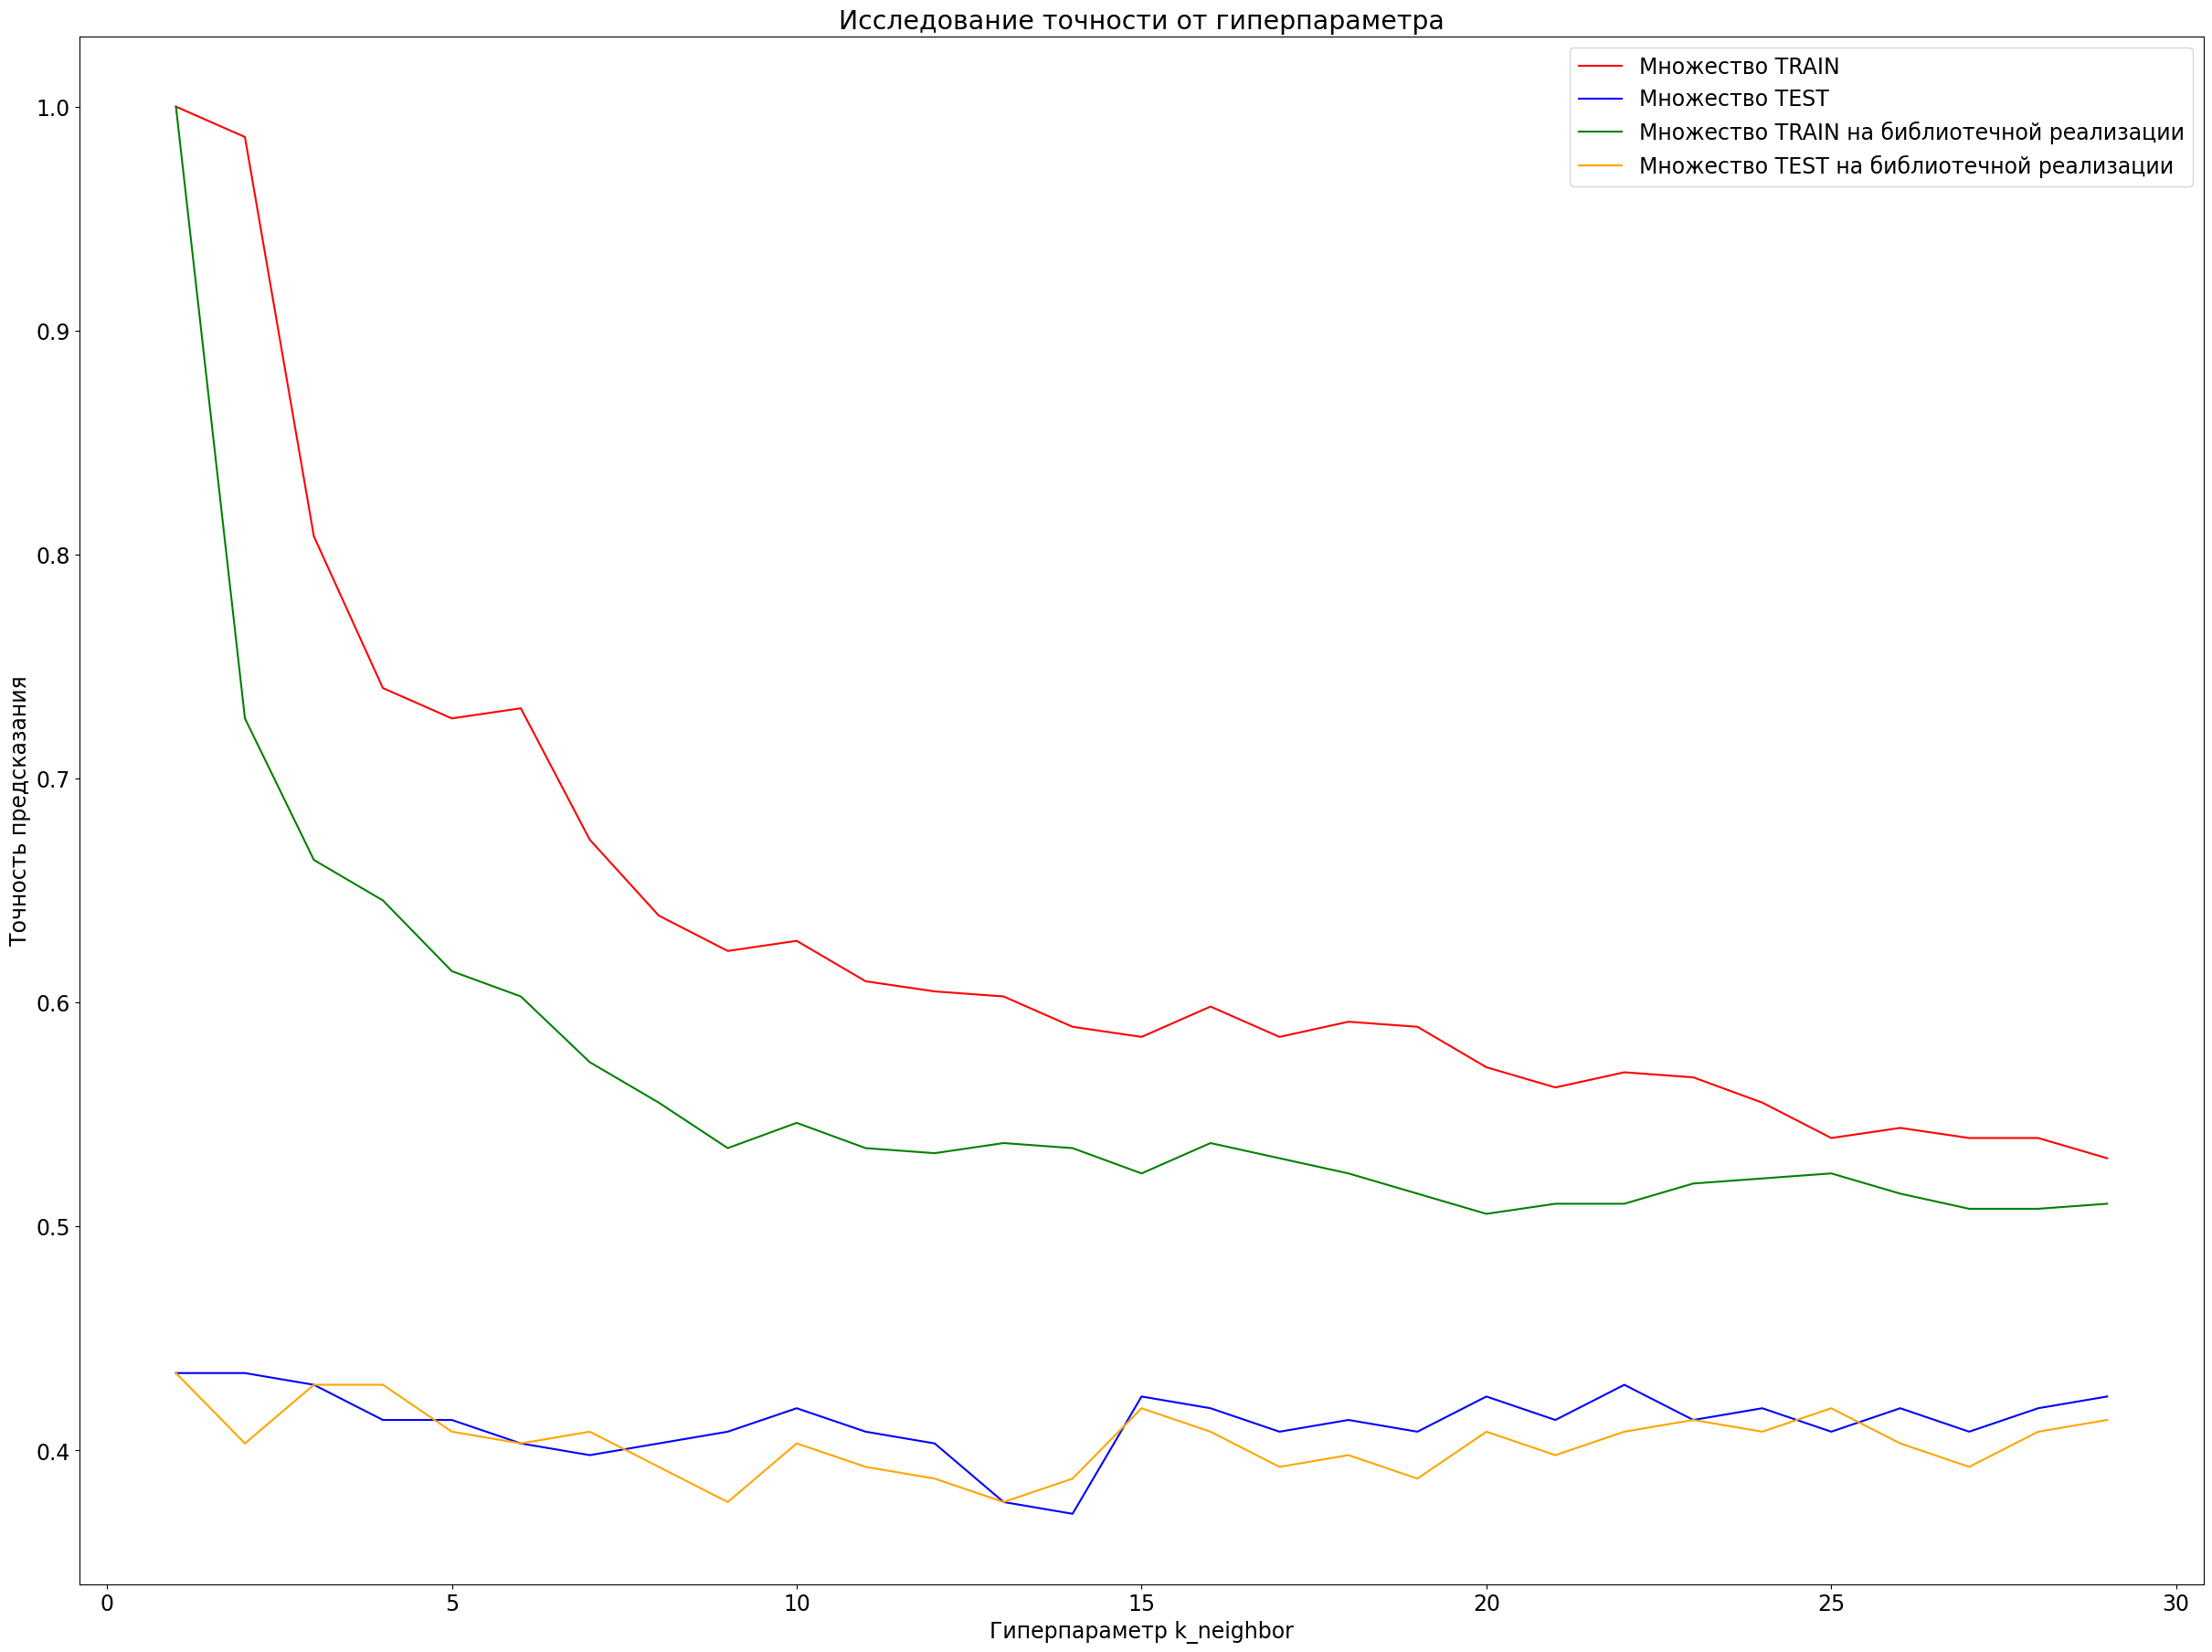

In [148]:
draw_accuracy(accuracy_train, accuracy_test, accuracy_train_library, accuracy_test_library, k_neighbors)

#### Обзор LOWESS

In [149]:
chandeliers_max_price = max(chandeliers[FEATURES_RU_EN["Цена"]])
chandeliers_min_price = min(chandeliers[FEATURES_RU_EN["Цена"]])
chandeliers_init_weights_name = "init_weights"

In [150]:
chandeliers_init_weights = [(val - chandeliers_min_price) / (chandeliers_max_price - chandeliers_min_price) * 0.9 + 0.1 for val in chandeliers[FEATURES_RU_EN["Цена"]]]

In [151]:
chandeliers[chandeliers_init_weights_name] = chandeliers_init_weights

In [152]:
chandeliers

,price,voltage,brand,diameter,height,color_reinforcement,color_shade,count_lamp,power,general_power,style,plinth,init_weights
144,9700,220.0,ST Luce,600.0,230.0,0,0,9,40.0,360.0,0,0,0.223846
151,9900,220.0,ST Luce,375.0,150.0,1,1,1,62.0,62.0,0,1,0.226981
652,9410,220.0,Vitaluce,790.0,385.0,0,2,6,40.0,240.0,1,0,0.219300
678,14500,230.0,ST Luce,600.0,500.0,1,3,8,40.0,420.0,2,0,0.299094
697,6080,230.0,Vitaluce,600.0,210.0,2,2,5,40.0,200.0,1,2,0.167096
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25834,33080,220.0,Reccagni Angelo,620.0,360.0,1,4,5,60.0,300.0,2,2,0.590368
25838,48130,220.0,Reccagni Angelo,540.0,360.0,1,4,3,60.0,180.0,2,2,0.826302
25876,46480,220.0,Reccagni Angelo,300.0,170.0,1,1,2,60.0,120.0,2,2,0.800435
26119,2560,220.0,Vitaluce,350.0,145.0,2,5,6,40.0,40.0,4,2,0.111914


In [153]:
target_inited: List[numpy.array] = []
features_inited: List[str] = []

In [154]:
for _, row in chandeliers.iterrows():
	collected_targets: List[float] = []
	for feat in FEATURES_EN_ALL:
		if feat == FEATURES_RU_EN[TARGET_PREDICT]:
			features_inited.append(row[feat])
		else:
			collected_targets.append(row[feat])
	collected_targets.append(row[chandeliers_init_weights_name])
	target_inited.append(numpy.array(collected_targets))

In [155]:
y_train, y_test, X_train_inited, X_test_inited = sklearn.model_selection.train_test_split(features_inited, target_inited, test_size = 0.3, random_state = 42)

In [156]:
def split_arrays(arrays: List[numpy.array]) -> Tuple[List[numpy.array], List[numpy.float64]]:
	array_list = []
	float_list = []
	for array in arrays:
		array_list.append(array[:-1])
		float_list.append(numpy.float64(array[-1]))
	return array_list, float_list

In [157]:
X_train, init_weights = split_arrays(X_train_inited)
X_test, _ = split_arrays(X_test_inited)

In [158]:
model = MyKNearestNeighborClassifier(distance_euclidean, kernel_uniform, False)

In [159]:
model.fit(X_train, y_train, init_weights)

[I 2024-03-28 23:06:14,509] A new study created in memory with name: no-name-11f77e71-9fce-493b-82ce-d7d72cb5e7b1
[I 2024-03-28 23:06:14,739] Trial 0 finished with value: 0.6821705426356589 and parameters: {'0': 0.8812227834871976, '1': 0.9440689775300474, '2': 0.05, '3': 0.5613133600418047, '4': 0.5499999999999999, '5': 0.5738460198571678, '6': 0.15000000000000002, '7': 0.3846542414213551, '8': 0.8478662253962727, '9': 0.9130465075770775, '10': 0.9067758230273475, '11': 0.998763281658248, '12': 0.8611391743598679, '13': 0.2, '14': 0.7726093015154156, '15': 0.1, '16': 0.1, '17': 0.7837571851593801, '18': 0.1, '19': 0.3365354467862742, '20': 0.9183852987284449, '21': 0.3504964291935203, '22': 0.8804476572025782, '23': 0.3788538582128549, '24': 0.1, '25': 0.4593015154154329, '26': 1, '27': 0.4120884863264239, '28': 0.7072287058003833, '29': 0.24719561052081518, '30': 0.7456279393833828, '31': 0.9149277129419965, '32': 0.6987632816582477, '33': 0.7732102421180981, '34': 1, '35': 0.05, '36

In [160]:
pred = [model.predict(item) for item in X_test]
expected = len(y_test)
actual = 0
for i in range(len(y_test)):
	if y_test[i] == pred[i]:
		actual += 1

In [161]:
print("Accuracy is %d%% where %d/%d" % (((actual / expected) * 100), actual, expected))

Accuracy is 32% where 63/191
